#Packages/Installations

In [1]:
!pip3 install nest_asyncio
!python3 -m pip install pystan
!python -m pip install Cython
!pip install nfl_data_py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.7 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13188 sha256=1d4b975999d5ed833e1aa5ee3ef0fa5452850ec8dcc20c65fdb8caadd29e925d
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import nfl_data_py as nfl
import nest_asyncio
import stan
import seaborn as sns
from scipy.stats import t, norm, expon, skewnorm, kstest
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

#Best Ball Mania Data

In [5]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/bbm_data.csv'
data = pd.read_csv(file_path, index_col=[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data = data[['draft_id', 'player_name', 'position_name', 'position_pick_number', 'year']]
data

,draft_id,player_name,position_name,position_pick_number,year
0,65219f4a-267e-4035-806a-646a3c1a846e,Stefon Diggs,WR,4,2023
1,65219f4a-267e-4035-806a-646a3c1a846e,Josh Allen,QB,1,2023
2,65219f4a-267e-4035-806a-646a3c1a846e,Keenan Allen,WR,16,2023
3,65219f4a-267e-4035-806a-646a3c1a846e,Christian Watson,WR,23,2023
4,65219f4a-267e-4035-806a-646a3c1a846e,T.J. Hockenson,TE,3,2023
...,...,...,...,...,...
22434313,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Kareem Hunt,RB,25,2021
22434314,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Amari Cooper,WR,11,2021
22434315,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Austin Hooper,TE,24,2021
22434316,ffff3a71-d0bb-491d-bce0-635aa2242d9f,D.J. Chark,WR,34,2021


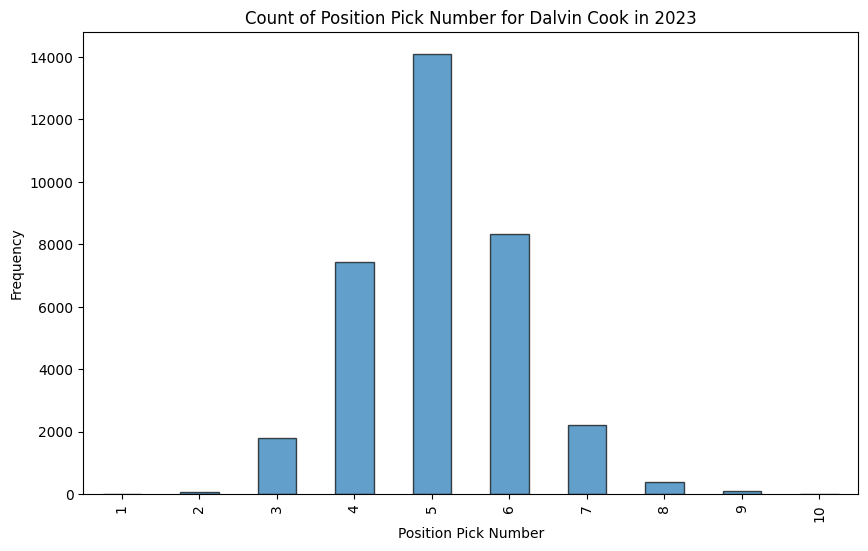

In [10]:
jt = data[(data['player_name'] == 'Dalvin Cook') & (data['year'] == 2022)]
position_counts = jt['position_pick_number'].value_counts().sort_index()

# Plot the counts as a bar plot
plt.figure(figsize=(10, 6))
position_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('Position Pick Number')
plt.ylabel('Frequency')
plt.title('Count of Position Pick Number for Dalvin Cook in 2023')
plt.show()

#Fantasy Points Data (NFL Data Py)

In [8]:
print([i for i in nfl.see_pbp_cols()])

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

In [12]:
nfl.see_weekly_cols()

Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_tds', 'fantasy_points

In [14]:
nfl_data = nfl.import_weekly_data([2021, 2022, 2023], columns = ['player_display_name', 'position', 'season', 'recent_team', 'week', 'fantasy_points', 'fantasy_points_ppr'])
nfl_data['fantasy_points_half_ppr'] = ((nfl_data['fantasy_points'] + nfl_data['fantasy_points_ppr']) / 2)
nfl_data['fantasy_points_half_ppr'] = nfl_data['fantasy_points_half_ppr']
nfl_data.drop(columns=['fantasy_points', 'fantasy_points_ppr'], inplace=True)
nfl_data

Downcasting floats.


,player_display_name,position,season,recent_team,week,fantasy_points_half_ppr
0,Tom Brady,QB,2021,TB,1,27.160000
1,Tom Brady,QB,2021,TB,2,29.639999
2,Tom Brady,QB,2021,TB,3,28.680000
3,Tom Brady,QB,2021,TB,4,11.060000
4,Tom Brady,QB,2021,TB,5,37.740002
...,...,...,...,...,...,...
5648,Zach Charbonnet,RB,2023,SEA,14,5.300000
5649,Zach Charbonnet,RB,2023,SEA,15,1.600000
5650,Zach Charbonnet,RB,2023,SEA,16,0.100000
5651,Zach Charbonnet,RB,2023,SEA,17,6.600000


In [17]:
player_season_team = nfl_data[['player_display_name', 'season', 'recent_team']].drop_duplicates()

# All weeks (assuming 17 weeks season)
all_weeks = list(range(1, 18))

# New rows to be added
new_rows = []

for _, row in player_season_team.iterrows():
    player, season, team = row['player_display_name'], row['season'], row['recent_team']

    # Weeks where the player has no entries
    player_weeks = nfl_data[(nfl_data['player_display_name'] == player) &
                            (nfl_data['season'] == season) &
                            (nfl_data['recent_team'] == team)]['week'].tolist()

    missing_weeks = set(all_weeks) - set(player_weeks)

    for week in missing_weeks:
        # Check if there is at least one entry for the same team in that week
        if not nfl_data[(nfl_data['season'] == season) & (nfl_data['recent_team'] == team) & (nfl_data['week'] == week)].empty:
            new_row = {
                'player_display_name': player,
                'position': nfl_data[(nfl_data['player_display_name'] == player)]['position'].values[0],
                'season': season,
                'recent_team': team,
                'week': week,
                'fantasy_points_half_ppr': 0
            }
            new_rows.append(new_row)

# Create a DataFrame for the new rows
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the new rows with the original dataframe
nfl_data = pd.concat([nfl_data, new_rows_df], ignore_index=True)

# Sort by player, season, week for better readability
nfl_data = nfl_data.sort_values(by=['player_display_name', 'season', 'week']).reset_index(drop=True)

In [18]:
nfl_data

,player_display_name,position,season,recent_team,week,fantasy_points_half_ppr
0,A.J. Brown,WR,2021,TEN,1,12.9
1,A.J. Brown,WR,2021,TEN,2,5.8
2,A.J. Brown,WR,2021,TEN,3,0.3
3,A.J. Brown,WR,2021,TEN,4,0.0
4,A.J. Brown,WR,2021,TEN,5,5.3
...,...,...,...,...,...,...
32555,Zonovan Knight,RB,2023,DET,13,0.0
32556,Zonovan Knight,RB,2023,DET,14,0.0
32557,Zonovan Knight,RB,2023,DET,15,0.0
32558,Zonovan Knight,RB,2023,DET,16,0.0


#Point Distribution EDA

In [ ]:
nfl_data = nfl_data[nfl_data['position'] == 'WR']

In [ ]:
nfl_data

,player_display_name,position,season,week,fantasy_points_half_ppr
74,Danny Amendola,WR,2021,1,11.900000
75,Danny Amendola,WR,2021,2,1.400000
76,Danny Amendola,WR,2021,7,3.200000
77,Danny Amendola,WR,2021,8,1.300000
78,Danny Amendola,WR,2021,9,6.400000
...,...,...,...,...,...
5586,Jayden Reed,WR,2023,15,14.200001
5587,Jayden Reed,WR,2023,17,23.900000
5588,Jayden Reed,WR,2023,18,13.200000
5589,Jayden Reed,WR,2023,19,0.000000


<ipython-input-29-2305564fa951>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nfl_data['normalized_points'] = nfl_data.groupby(['player_display_name', 'season'])['fantasy_points_half_ppr'].transform(


Skew-Normal Distribution - KS Statistic: 0.04027559147476306 P-value: 4.991782379732087e-10


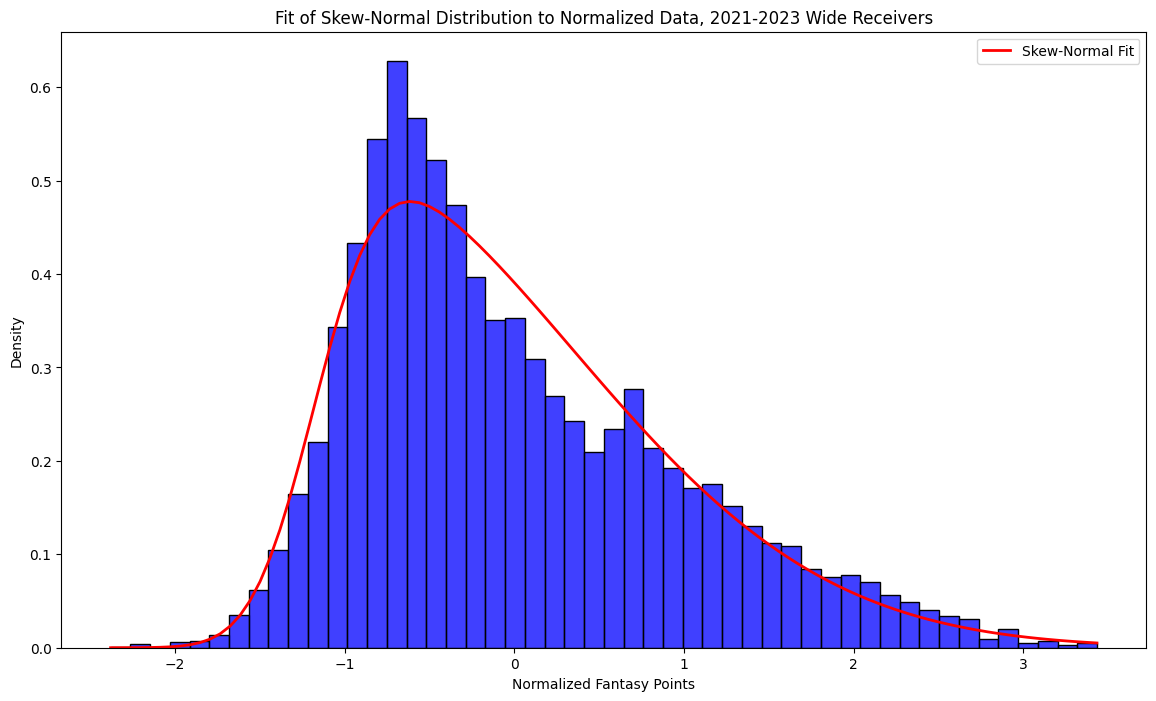

In [ ]:
nfl_data['normalized_points'] = nfl_data.groupby(['player_display_name', 'season'])['fantasy_points_half_ppr'].transform(
    lambda x: (x - x.mean()) / x.std()
)

nfl_data = nfl_data[np.isfinite(nfl_data['normalized_points'])]

# Fit a skew-normal distribution
data = nfl_data['normalized_points']
ae, loc, scale = skewnorm.fit(data)

ks_stat, ks_p_value = kstest(data, 'skewnorm', args=(ae, loc, scale))
print("Skew-Normal Distribution - KS Statistic:", ks_stat, "P-value:", ks_p_value)
# Plot the histogram and the fitted distribution
plt.figure(figsize=(14, 8))
sns.histplot(data, kde=False, bins=50, color='blue', stat='density')
data_range = np.linspace(data.min(), data.max(), 100)
plt.plot(data_range, skewnorm.pdf(data_range, ae, loc, scale), 'r-', linewidth=2, label='Skew-Normal Fit')

# Plot details
plt.title('Fit of Skew-Normal Distribution to Normalized Data, 2021-2023 Wide Receivers')
plt.xlabel('Normalized Fantasy Points')
plt.ylabel('Density')
plt.legend()
plt.show()

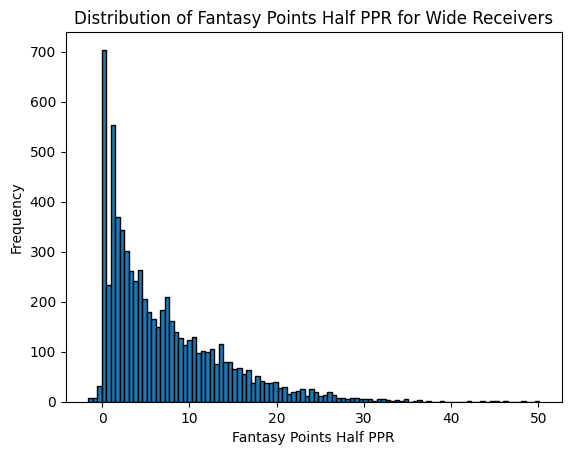

In [ ]:
plt.hist(nfl_data['fantasy_points_half_ppr'], bins=100, edgecolor='black')
plt.xlabel('Fantasy Points Half PPR')
plt.ylabel('Frequency')
plt.title('Distribution of Fantasy Points Half PPR for Wide Receivers')
plt.show()

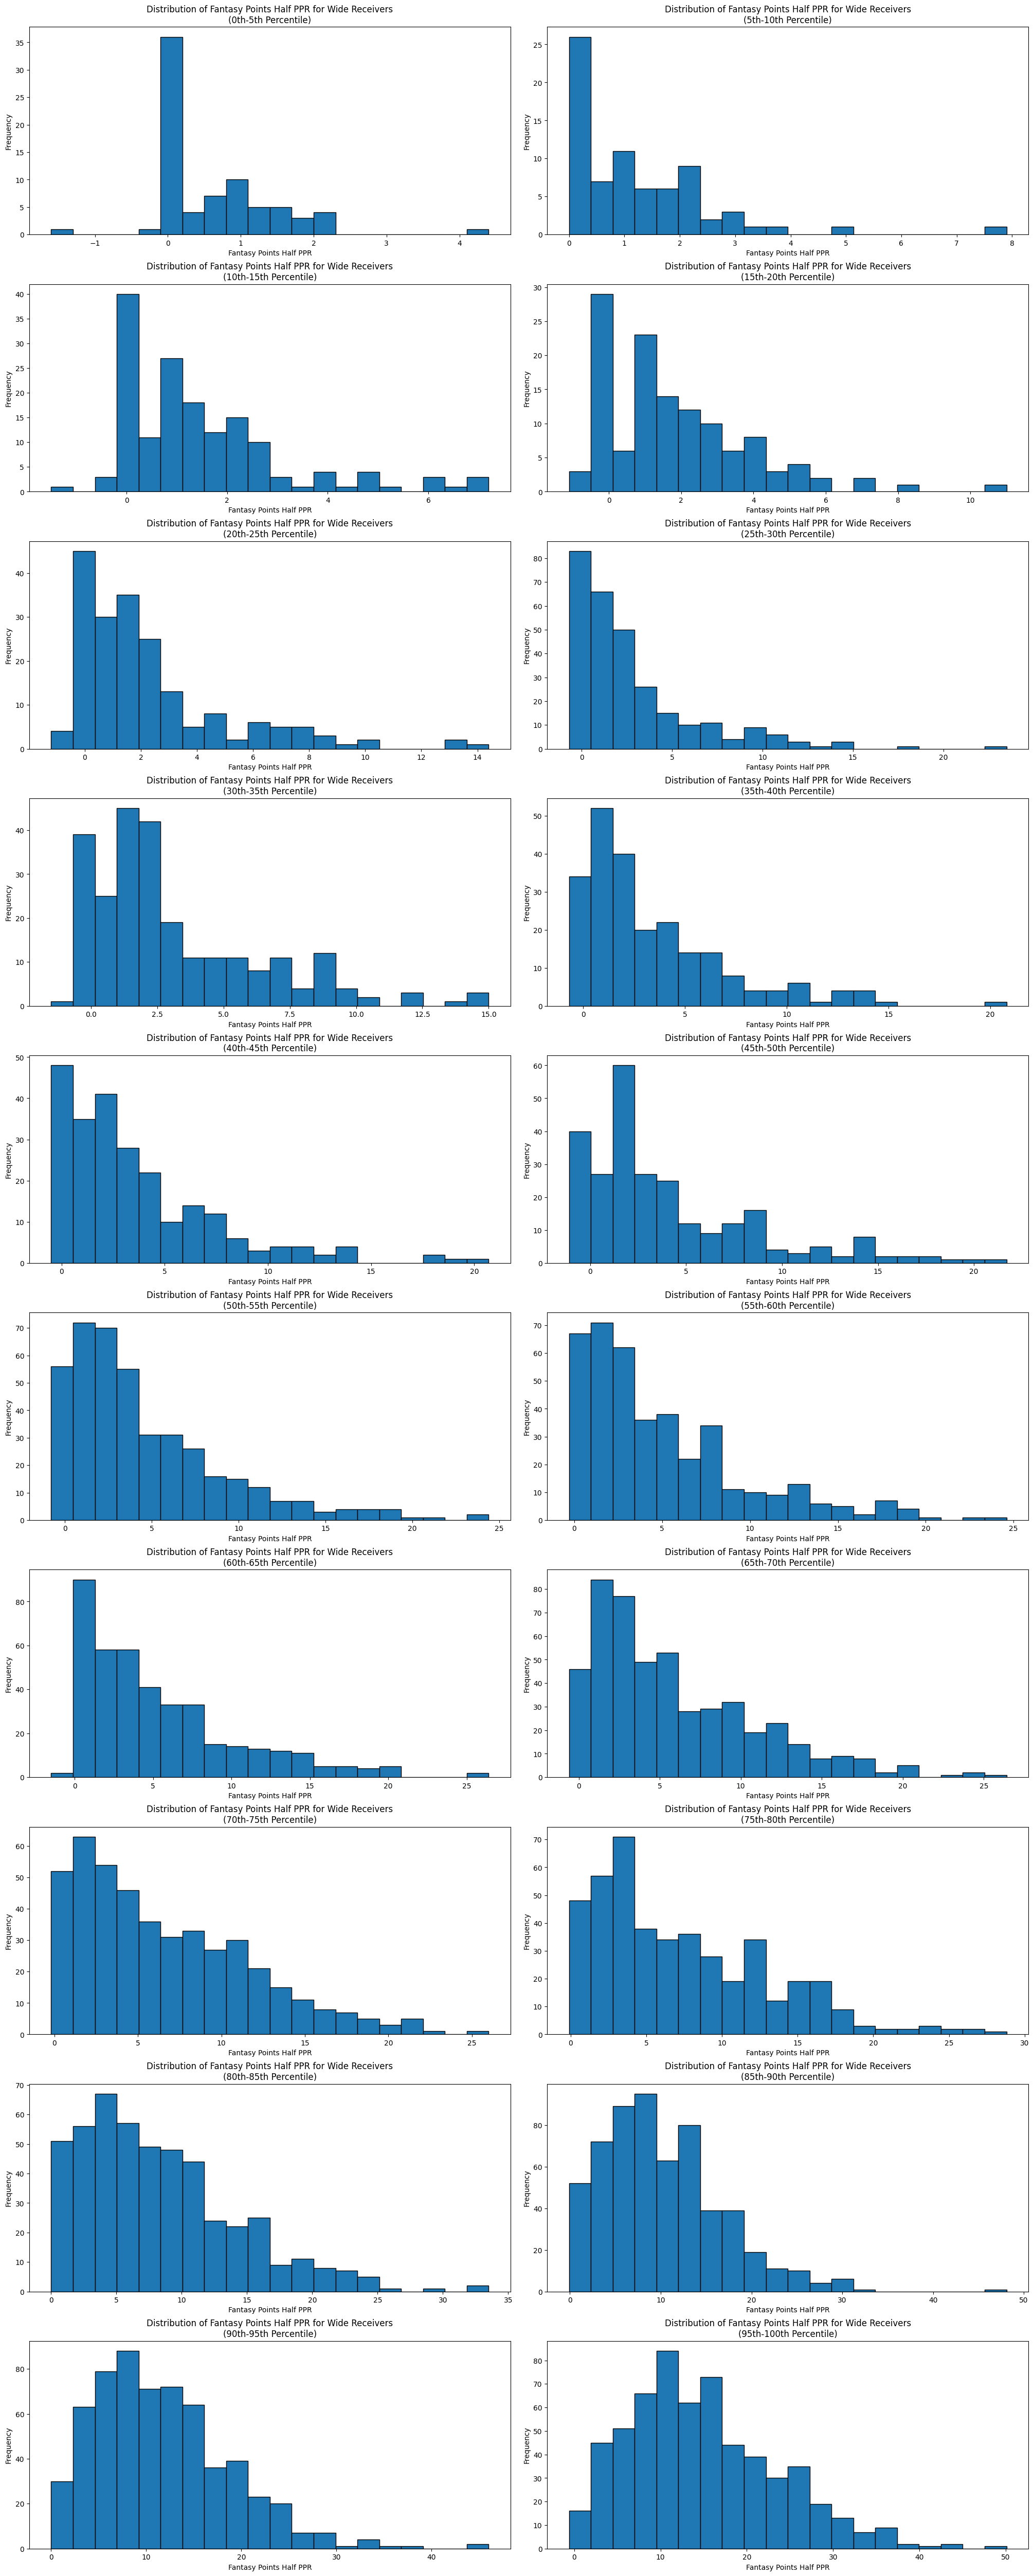

In [ ]:
wr_data = nfl_data[nfl_data['position'] == 'WR']

# Calculate average fantasy points per player in the season
avg_points_per_player = wr_data.groupby('player_display_name')['fantasy_points_half_ppr'].mean().reset_index()
avg_points_per_player.columns = ['player_display_name', 'avg_fantasy_points']

# Merge back to get the full dataset with average points
wr_data = pd.merge(wr_data, avg_points_per_player, on='player_display_name')

# Determine the percentiles
percentiles = np.percentile(avg_points_per_player['avg_fantasy_points'], np.arange(5, 105, 5))

# Function to filter data based on percentile range
def get_data_for_percentile_range(data, lower, upper):
    return data[(data['avg_fantasy_points'] >= lower) & (data['avg_fantasy_points'] < upper)]

# Plot distributions
fig, axs = plt.subplots(10, 2, figsize=(20, 50), constrained_layout=True)

titles = [f'{i*5}th-{(i+1)*5}th Percentile' for i in range(20)]

for i in range(20):
    lower = percentiles[i-1] if i > 0 else -np.inf
    upper = percentiles[i]
    data = get_data_for_percentile_range(wr_data, lower, upper)
    row, col = divmod(i, 2)
    axs[row, col].hist(data['fantasy_points_half_ppr'], bins=20, edgecolor='black')
    axs[row, col].set_title(f'Distribution of Fantasy Points Half PPR for Wide Receivers\n({titles[i]})')
    axs[row, col].set_xlabel('Fantasy Points Half PPR')
    axs[row, col].set_ylabel('Frequency')

plt.show()

In [ ]:
file_path = 'betareg.stan'

# Open and read the file
with open(file_path, 'r') as file:
    stan_code = file.read()

# Print the contents of the file
print(stan_code)

data {
  int<lower=0> n;                          // number of datapoints
  int<lower=0> m;                          // number of columns in the draft_pick basis matrix
  int<lower=0> num_pos;                    // number of positions
  real x[n];                               // draft pick x values 
  real xmat[n,m];                          // basis matrix of draft pick x values 
  int<lower=1,upper=num_pos> pos_idx[n];   // vector of position indices
  int<lower=0,upper=1> bust[n];            // vector of `bust` indicator values
  real<lower=0,upper=1> y[n];              // vector of response values `apy_cap_pct_2C`

  int<lower=0> n_new;                      
  real x_new[n_new];        
  real xmat_new[n_new,m];        
  int<lower=1,upper=num_pos> pos_idx_new[n_new];      
}
parameters {
  // positional parameters
  real alpha_0[num_pos];
  real alpha_1[num_pos];
  real beta[num_pos,m];  
  real gamma_0[num_pos];
  real gamma_1[num_pos];
  
  // top-level positionless mean parame

#ADP-Performance Distribution EDA


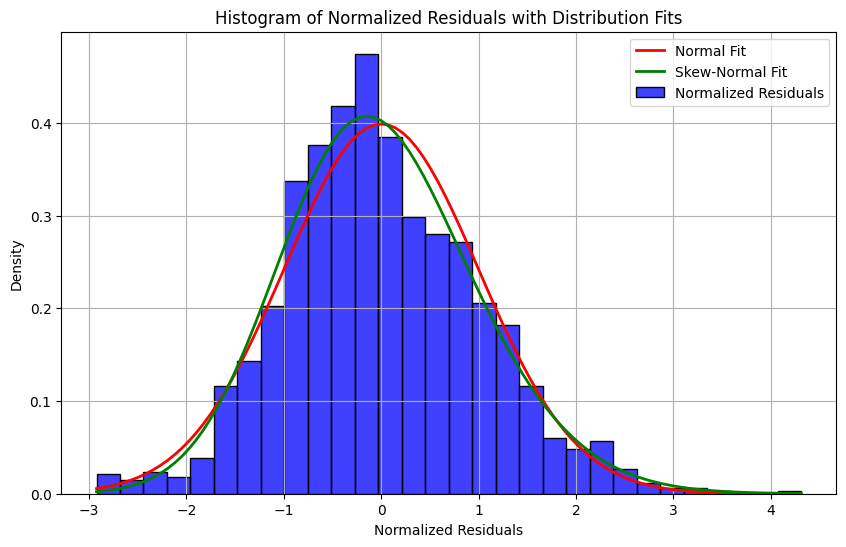

In [ ]:
merged_data_by_year['position_pick_number_sq'] = merged_data_by_year['position_pick_number'] ** 2
X = merged_data_by_year[['position_pick_number', 'position_pick_number_sq']]
y = merged_data_by_year['fantasy_points_half_ppr']

# Fit the quadratic model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Step 2: Calculate residuals
residuals = y - y_pred

# Step 3: Normalize the residuals
scaler = StandardScaler()
residuals_normalized = scaler.fit_transform(residuals.values.reshape(-1, 1)).flatten()

# Step 4: Plot the histogram of normalized residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_normalized, bins=30, kde=False, color='blue', stat='density', label='Normalized Residuals')

# Step 5: Fit distributions and plot them
# Fit a normal distribution
params_norm = norm.fit(residuals_normalized)
x = np.linspace(residuals_normalized.min(), residuals_normalized.max(), 100)
pdf_norm = norm.pdf(x, *params_norm)

# Fit a skew-normal distribution
params_skewnorm = skewnorm.fit(residuals_normalized)
pdf_skewnorm = skewnorm.pdf(x, *params_skewnorm)

# Overlay the distributions
plt.plot(x, pdf_norm, 'r-', linewidth=2, label='Normal Fit')
plt.plot(x, pdf_skewnorm, 'g-', linewidth=2, label='Skew-Normal Fit')

# Final touches to the plot
plt.title('Histogram of Normalized Residuals with Distribution Fits')
plt.xlabel('Normalized Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ks_stat_norm, ks_p_value_norm = kstest(residuals_normalized, 'norm', args=params_norm)
print("Normal Distribution - KS Statistic:", ks_stat_norm, "P-value:", ks_p_value_norm)

# Perform the K-S test for the skew-normal distribution
ks_stat_skewnorm, ks_p_value_skewnorm = kstest(residuals_normalized, 'skewnorm', args=params_skewnorm)
print("Skew-Normal Distribution - KS Statistic:", ks_stat_skewnorm, "P-value:", ks_p_value_skewnorm)

Normal Distribution - KS Statistic: 0.042776787298242636 P-value: 0.012034557931495148
Skew-Normal Distribution - KS Statistic: 0.023306803883234917 P-value: 0.43097188119335705


#Fitting Baseline STAN Model

In [ ]:
nest_asyncio.apply()

In [ ]:
mean_fantasy_points_by_year = nfl_data.groupby(['player_display_name', 'season'])['fantasy_points_half_ppr'].mean().reset_index()
mean_position_pick_number_by_year = data.groupby(['player_name', 'year', 'position_name'])['position_pick_number'].mean().reset_index()

merged_data_by_year = mean_fantasy_points_by_year.merge(
    mean_position_pick_number_by_year,
    left_on=['player_display_name', 'season'],
    right_on=['player_name', 'year'],
    how='inner'
).drop(columns=['player_name', 'season'])

In [ ]:
merged_data_by_year

,player_display_name,fantasy_points_half_ppr,year,position_name,position_pick_number
0,A.J. Brown,12.292857,2021,WR,6.687597
1,A.J. Brown,14.135000,2022,WR,10.732179
2,A.J. Brown,13.917647,2023,WR,6.100004
3,A.J. Green,7.635294,2021,WR,75.090923
4,A.J. Green,3.815384,2022,WR,83.498659
...,...,...,...,...,...
1384,Zay Jones,6.062500,2021,WR,96.500000
1385,Zay Jones,10.294445,2022,WR,82.752882
1386,Zay Jones,6.788889,2023,WR,56.383503
1387,Zonovan Knight,7.500000,2022,RB,58.250000


In [ ]:
mean_fantasy_points_by_year

,player_display_name,season,fantasy_points_half_ppr
0,A.J. Brown,2021,12.292857
1,A.J. Brown,2022,14.135000
2,A.J. Brown,2023,13.917647
3,A.J. Dillon,2021,9.838888
4,A.J. Dillon,2022,9.035295
...,...,...,...
1867,Zay Jones,2021,6.062500
1868,Zay Jones,2022,10.294445
1869,Zay Jones,2023,6.788889
1870,Zonovan Knight,2022,7.500000


In [ ]:
merged_data_by_year

,player_display_name,fantasy_points_half_ppr,year,position_name,position_pick_number
0,A.J. Brown,12.292857,2021,WR,6.687597
1,A.J. Brown,14.135000,2022,WR,10.732179
2,A.J. Brown,13.917647,2023,WR,6.100004
3,A.J. Green,7.635294,2021,WR,75.090923
4,A.J. Green,3.815384,2022,WR,83.498659
...,...,...,...,...,...
1384,Zay Jones,6.062500,2021,WR,96.500000
1385,Zay Jones,10.294445,2022,WR,82.752882
1386,Zay Jones,6.788889,2023,WR,56.383503
1387,Zonovan Knight,7.500000,2022,RB,58.250000


In [ ]:
df_wr = merged_data_by_year[merged_data_by_year['position_name'] == 'WR']

stan_data = {
    'N': len(df_wr),
    'position_pick_number': df_wr['position_pick_number'].values,
    'fantasy_points_half_ppr': df_wr['fantasy_points_half_ppr'].values
}

In [ ]:
stan_code = """
data {
  int<lower=0> N; // Number of data points
  vector[N] position_pick_number; // Predictor
  vector[N] fantasy_points_half_ppr; // Response
}

parameters {
  real alpha; // Intercept
  real beta1; // Linear term
  real beta2; // Quadratic term
  real sigma_alpha;
  real sigma_beta1;
  // real<lower=0> sigma Standard deviation of the residuals
}

model {
  // Priors
  alpha ~ normal(0, 10);
  sigma_alpha ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  sigma_alpha ~ normal(0, 10);
  beta2 ~ normal(0, 10);

  // Likelihood
  fantasy_points_half_ppr ~ normal(alpha + beta1 * position_pick_number + beta2 * square(position_pick_number), sigma_alpha + sigma_beta1 * position_pick_number);
}
"""

# Compile the model
model = stan.build(stan_code, data=stan_data)

# Sample from the posterior
fit = model.sample(num_chains=4, num_samples=1000)

Building...



Building: 45.9s, done.Messages from stanc:
Warning in '/tmp/httpstan_09c94pti/model_qjoqhukn.stan', line 20, column 2: The
    parameter sigma_alpha is on the left-hand side of more than one tilde
    statement.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1701/8000)
Sampling:  23% (1801/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2301/8000)


In [ ]:
fit_df = fit.to_frame()
print(fit_df.describe())

parameters         lp__  accept_stat__   stepsize__  treedepth__  \
count       4000.000000    4000.000000  4000.000000  4000.000000   
mean        -824.444548       0.931982     0.006218     7.682250   
std            1.545787       0.093727     0.000169     1.425936   
min         -833.299486       0.310295     0.006017     1.000000   
25%         -825.229361       0.905221     0.006107     7.000000   
50%         -824.113479       0.972324     0.006188     8.000000   
75%         -823.302964       0.995630     0.006300     9.000000   
max         -822.095856       1.000000     0.006477    10.000000   

parameters  n_leapfrog__  divergent__     energy__        alpha        beta1  \
count        4000.000000       4000.0  4000.000000  4000.000000  4000.000000   
mean          393.634500          0.0   826.958709    14.815847    -0.176554   
std           276.483886          0.0     2.259527     0.520812     0.022464   
min             1.000000          0.0   822.388330    12.913150    

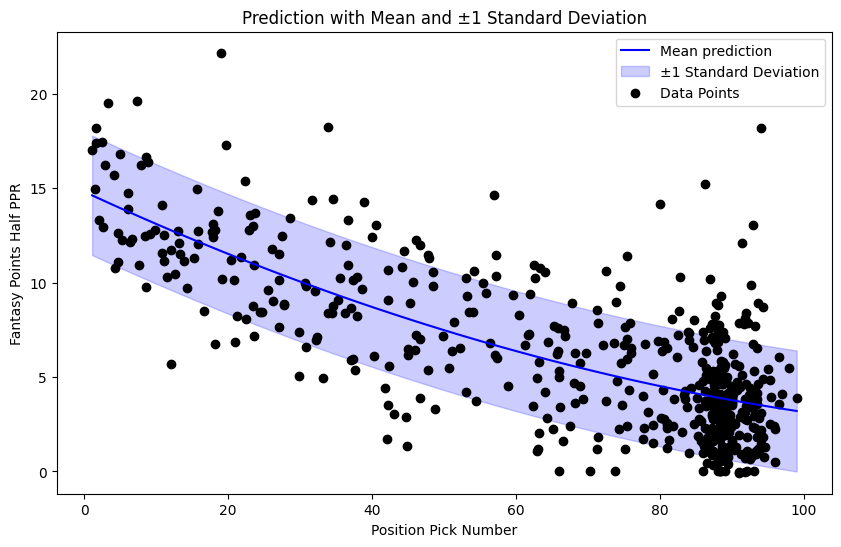

In [ ]:
posterior_samples = fit.to_frame()
alpha_samples = posterior_samples['alpha']
beta1_samples = posterior_samples['beta1']
beta2_samples = posterior_samples['beta2']
sigma_alpha_samples = posterior_samples['sigma_alpha']
sigma_beta1_samples = posterior_samples['sigma_beta1']

# Calculate the mean and standard deviation of the parameters
alpha_mean = np.mean(alpha_samples)
beta1_mean = np.mean(beta1_samples)
beta2_mean = np.mean(beta2_samples)
sigma_alpha_mean = np.mean(sigma_alpha_samples)
sigma_beta1_mean = np.mean(sigma_beta1_samples)

# Define the position pick number range for the plot
x = np.linspace(min(stan_data['position_pick_number']), max(stan_data['position_pick_number']), 100)

# Calculate the mean predicted values
y_mean = alpha_mean + beta1_mean * x + beta2_mean * np.square(x)

# Calculate the standard deviation of the predictions
y_std = np.sqrt(sigma_alpha_mean**2 + (sigma_beta1_mean * x)**2)

# Plot the mean and ±1 standard deviation
plt.figure(figsize=(10, 6))
plt.plot(x, y_mean, label='Mean prediction', color='blue')
plt.fill_between(x, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='±1 Standard Deviation')
plt.scatter(stan_data['position_pick_number'], stan_data['fantasy_points_half_ppr'], color='black', label='Data Points')
plt.xlabel('Position Pick Number')
plt.ylabel('Fantasy Points Half PPR')
plt.title('Prediction with Mean and ±1 Standard Deviation')
plt.legend()
plt.show()

#Random Models, Skew-Normal Failures

In [ ]:
nest_asyncio.apply()
data['avg_draft_position'] = data.groupby(['year', 'player_name'])['position_pick_number'].transform('mean')
data = data[['player_name', 'position_name', 'year', 'avg_draft_position']].drop_duplicates()
merged_data = pd.merge(nfl_data, data, how='inner',
                       left_on=['player_display_name', 'position', 'season'],
                       right_on=['player_name', 'position_name', 'year'])

merged_data = merged_data[['player_display_name', 'position', 'season', 'week', 'fantasy_points_half_ppr', 'avg_draft_position']]

In [ ]:
merged_data['player_year_id'] = pd.factorize(merged_data['player_display_name'].astype(str) + '_' + merged_data['season'].astype(str))[0] + 1  # Ensure 1-indexing for Stan

In [ ]:
merged_data = merged_data[merged_data['position'] == 'WR']

In [ ]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position,player_year_id
72,Danny Amendola,WR,2021,1,11.900000,88.000000,7
73,Danny Amendola,WR,2021,2,1.400000,88.000000,7
74,Danny Amendola,WR,2021,7,3.200000,88.000000,7
75,Danny Amendola,WR,2021,8,1.300000,88.000000,7
76,Danny Amendola,WR,2021,9,6.400000,88.000000,7
...,...,...,...,...,...,...,...
14654,Jayden Reed,WR,2023,15,14.200001,72.504599,1373
14655,Jayden Reed,WR,2023,17,23.900000,72.504599,1373
14656,Jayden Reed,WR,2023,18,13.200000,72.504599,1373
14657,Jayden Reed,WR,2023,19,0.000000,72.504599,1373


In [ ]:
merged_data['player_year_id'] = merged_data.groupby(['player_display_name', 'season']).ngroup() + 1


In [ ]:
min(merged_data['player_year_id'])

1

In [ ]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position,player_year_id
72,Danny Amendola,WR,2021,1,11.900000,88.000000,120
73,Danny Amendola,WR,2021,2,1.400000,88.000000,120
74,Danny Amendola,WR,2021,7,3.200000,88.000000,120
75,Danny Amendola,WR,2021,8,1.300000,88.000000,120
76,Danny Amendola,WR,2021,9,6.400000,88.000000,120
...,...,...,...,...,...,...,...
14654,Jayden Reed,WR,2023,15,14.200001,72.504599,264
14655,Jayden Reed,WR,2023,17,23.900000,72.504599,264
14656,Jayden Reed,WR,2023,18,13.200000,72.504599,264
14657,Jayden Reed,WR,2023,19,0.000000,72.504599,264


In [ ]:
min(merged_data['player_year_id'])

1

In [ ]:
import stan

In [ ]:
stan_model_code = """
data {
  int<lower=0> N;  // number of data points
  int<lower=0> K;  // number of wide receivers
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector[K] alpha;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model
  real beta1;  // linear coefficient for the quadratic model
  real beta2;  // quadratic coefficient for the quadratic model
  real<lower=0> sigma;  // standard deviation of the weekly scores
  real<lower=0> tau;  // standard deviation of the alpha's
}

model {
  vector[K] mu;

  // Prior distributions
  beta0 ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  tau ~ normal(0, 5);
  sigma ~ normal(0, 5);

  // Quadratic model for the means
  for (k in 1:K) {
    mu[k] = beta0 + beta1 * adp[k] + beta2 * adp[k] * adp[k];
  }

  // Hierarchical model for alpha
  alpha ~ normal(mu, tau);

  // Likelihood
  for (n in 1:N) {
    weekly_score[n] ~ normal(alpha[receiver[n]], sigma);
  }
}
"""

In [ ]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector[K] alpha;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model
  real beta1;  // linear coefficient for the quadratic model
  real beta2;  // quadratic coefficient for the quadratic model
  real<lower=0> sigma;  // standard deviation of the weekly scores
  real<lower=0> tau;  // standard deviation of the alpha's
}

transformed parameters {
  vector[K] mu; // overall mean of alphas
  for (k in 1:K) {
    mu[k] = beta0 + beta1 * adp[k] + beta2 * adp[k] * adp[k];
  }
}

model {
  // likelihood
  for (n in 1:N) {
    weekly_score[n] ~ normal(alpha[receiver[n]], sigma);
  }
  //
  alpha ~ normal(mu, tau);

  // Prior distributions
  beta0 ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  tau ~ normal(0, 10);
  sigma ~ normal(0, 10);
}
"""

In [ ]:
def prepare_stan_data(df):
    # Ensure the player_year_id column is unique per player and season
    df['receiver_index'] = df['player_year_id'].astype('category').cat.codes + 1
    N = df.shape[0]
    K = df['receiver_index'].nunique()
    receiver = df['receiver_index'].values
    weekly_score = df['fantasy_points_half_ppr'].values
    adp = df.drop_duplicates(subset=['player_year_id'])[['receiver_index', 'avg_draft_position']].sort_values('receiver_index')['avg_draft_position'].values

    stan_data = {
        'N': N,
        'K': K,
        'receiver': receiver.tolist(),
        'weekly_score': weekly_score.tolist(),
        'adp': adp.tolist()
    }

    return stan_data

# Prepare the data
stan_data = prepare_stan_data(merged_data)

# Compile the Stan model
stan_model = stan.build(stan_model_code, data=stan_data)

# Fit the Stan model
fit = stan_model.sample(num_chains=1, num_samples=10)
#fit = stan_model.sample(num_chains=4, num_samples=2000)

# Print the summary of the fit
print(fit)

# Extract the samples for further analysis
samples = fit.to_frame()

# For example, to get the posterior means of beta coefficients
beta0_mean = samples['beta0'].mean()
beta1_mean = samples['beta1'].mean()
beta2_mean = samples['beta2'].mean()

print(f'Posterior means of beta coefficients: beta0 = {beta0_mean}, beta1 = {beta1_mean}, beta2 = {beta2_mean}')

Building...



Building: 57.8s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1010)
Sampling:  10% (100/1010)
Sampling:  20% (200/1010)
Sampling:  30% (300/1010)
Sampling:  40% (400/1010)
Sampling:  50% (500/1010)
Sampling:  59% (600/1010)
Sampling:  69% (700/1010)
Sampling:  79% (800/1010)
Sampling:  89% (900/1010)
Sampling:  99% (1000/1010)
Sampling:  99% (1001/1010)
Sampling: 100% (1010/1010)
Sampling: 100% (1010/1010), done.
Messages received during sampling:
  Gradient evaluation took 0.001678 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.78 seconds.
  Adjust your expectations accordingly!


<stan.Fit>
Parameters:
    alpha: (533,)
    beta0: ()
    beta1: ()
    beta2: ()
    sigma: ()
    tau: ()
    mu: (533,)
Draws: 10
Posterior means of beta coefficients: beta0 = 10.368617470357965, beta1 = -0.15227182939774916, beta2 = 0.0006782418157608297


In [ ]:
samples

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha.1,alpha.2,alpha.3,...,mu.524,mu.525,mu.526,mu.527,mu.528,mu.529,mu.530,mu.531,mu.532,mu.533
draws,,,,,,,,,,,,,,,,,,,,,
0,-15359.158354,0.984497,0.004412,10.0,1023.0,0.0,15771.015940,11.353193,5.388575,9.593682,...,2.068840,2.094745,2.055107,1.953755,1.987562,2.083720,4.773475,1.807844,2.220788,3.651830
1,-15344.701754,0.954996,0.004412,10.0,1023.0,0.0,15625.610445,11.031086,5.751995,9.568801,...,1.795325,1.847122,1.767340,1.547508,1.623712,1.825231,5.103978,1.169867,2.083465,3.990273
2,-15284.308026,0.998832,0.004412,10.0,1023.0,0.0,15622.238656,10.675922,6.299322,9.534287,...,2.139461,2.180678,2.117314,1.946386,2.005019,2.163222,5.261282,1.665887,2.372398,4.112075
3,-15229.975751,0.999680,0.004412,10.0,1023.0,0.0,15558.670649,10.928893,6.452803,8.933889,...,2.295393,2.317743,2.283655,2.199835,2.227186,2.308198,5.071867,2.092068,2.429799,3.865899
4,-15207.972197,0.999328,0.004412,10.0,1023.0,0.0,15485.731230,10.253921,6.548035,9.224763,...,2.194354,2.226266,2.177360,2.050013,2.092907,2.212707,5.221941,1.857813,2.379267,4.003824
5,-15177.558353,0.986367,0.004412,10.0,1023.0,0.0,15501.354466,12.482072,6.573818,9.337379,...,2.358849,2.368153,2.354301,2.330477,2.336317,2.364081,4.867120,2.340952,2.424902,3.637711
6,-15162.990566,0.991867,0.004412,10.0,1023.0,0.0,15451.622062,13.998254,6.634191,9.191049,...,2.273994,2.309025,2.255378,2.116850,2.163304,2.294129,5.751404,1.912173,2.478125,4.331440
7,-15167.350089,0.990883,0.004412,10.0,1023.0,0.0,15445.172159,11.210827,6.659349,9.881249,...,2.392115,2.387121,2.395454,2.437626,2.419767,2.389044,4.637296,2.578934,2.383493,3.365628
8,-15117.448034,0.989583,0.004412,10.0,1023.0,0.0,15445.738028,11.462457,6.578980,10.888487,...,2.435244,2.455373,2.424727,2.351028,2.374765,2.446761,5.154486,2.262921,2.557925,3.950747


In [ ]:
samples[['beta0', 'beta1', 'beta2']].describe()

parameters,beta0,beta1,beta2
count,10.000000,10.000000,10.000000
mean,10.368617,-0.152272,0.000678
std,0.902329,0.034608,0.000315
min,8.748318,-0.215732,0.000146
25%,9.705247,-0.168841,0.000559
50%,10.494922,-0.150932,0.000665
75%,10.816961,-0.138851,0.000773
max,11.680453,-0.092615,0.001283


In [ ]:
len(stan_data['adp'])

533

In [ ]:
len(alpha_means)

0

In [ ]:
samples

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha.1,alpha.2,alpha.3,...,mu.524,mu.525,mu.526,mu.527,mu.528,mu.529,mu.530,mu.531,mu.532,mu.533
draws,,,,,,,,,,,,,,,,,,,,,
0,-15359.158354,0.984497,0.004412,10.0,1023.0,0.0,15771.015940,11.353193,5.388575,9.593682,...,2.068840,2.094745,2.055107,1.953755,1.987562,2.083720,4.773475,1.807844,2.220788,3.651830
1,-15344.701754,0.954996,0.004412,10.0,1023.0,0.0,15625.610445,11.031086,5.751995,9.568801,...,1.795325,1.847122,1.767340,1.547508,1.623712,1.825231,5.103978,1.169867,2.083465,3.990273
2,-15284.308026,0.998832,0.004412,10.0,1023.0,0.0,15622.238656,10.675922,6.299322,9.534287,...,2.139461,2.180678,2.117314,1.946386,2.005019,2.163222,5.261282,1.665887,2.372398,4.112075
3,-15229.975751,0.999680,0.004412,10.0,1023.0,0.0,15558.670649,10.928893,6.452803,8.933889,...,2.295393,2.317743,2.283655,2.199835,2.227186,2.308198,5.071867,2.092068,2.429799,3.865899
4,-15207.972197,0.999328,0.004412,10.0,1023.0,0.0,15485.731230,10.253921,6.548035,9.224763,...,2.194354,2.226266,2.177360,2.050013,2.092907,2.212707,5.221941,1.857813,2.379267,4.003824
5,-15177.558353,0.986367,0.004412,10.0,1023.0,0.0,15501.354466,12.482072,6.573818,9.337379,...,2.358849,2.368153,2.354301,2.330477,2.336317,2.364081,4.867120,2.340952,2.424902,3.637711
6,-15162.990566,0.991867,0.004412,10.0,1023.0,0.0,15451.622062,13.998254,6.634191,9.191049,...,2.273994,2.309025,2.255378,2.116850,2.163304,2.294129,5.751404,1.912173,2.478125,4.331440
7,-15167.350089,0.990883,0.004412,10.0,1023.0,0.0,15445.172159,11.210827,6.659349,9.881249,...,2.392115,2.387121,2.395454,2.437626,2.419767,2.389044,4.637296,2.578934,2.383493,3.365628
8,-15117.448034,0.989583,0.004412,10.0,1023.0,0.0,15445.738028,11.462457,6.578980,10.888487,...,2.435244,2.455373,2.424727,2.351028,2.374765,2.446761,5.154486,2.262921,2.557925,3.950747


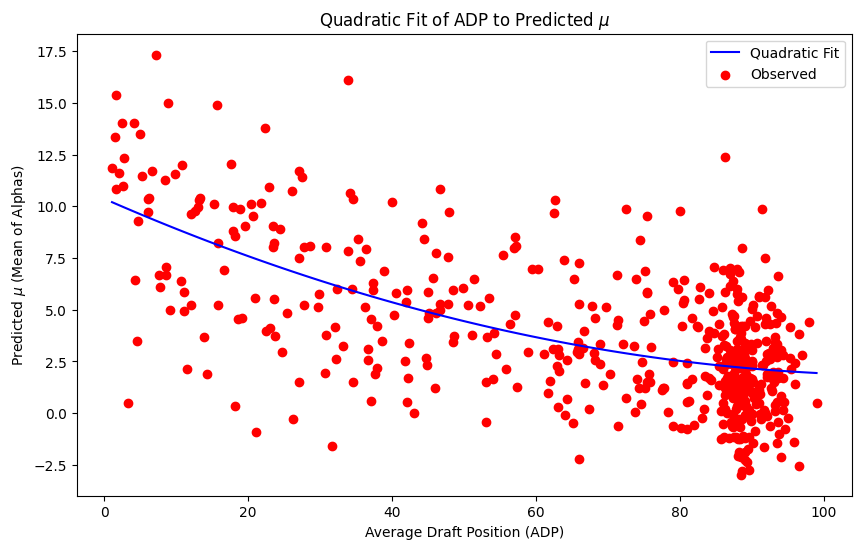

In [ ]:
beta0_mean = samples['beta0'].mean()
beta1_mean = samples['beta1'].mean()
beta2_mean = samples['beta2'].mean()

# Create a sequence of ADP values for the plot
adp_values = np.linspace(min(stan_data['adp']), max(stan_data['adp']), 100)

# Calculate the predicted mu for each ADP value
predicted_mu = beta0_mean + beta1_mean * adp_values + beta2_mean * adp_values**2

# Extract the mean of alphas for each receiver
# Ensure the number of alpha means matches the number of unique player_year_ids
alpha_columns = [col for col in samples.columns if col.startswith('alpha.')]
alpha_means = samples[alpha_columns].mean(axis=0).values

# Plot ADP vs predicted mu
plt.figure(figsize=(10, 6))
plt.plot(adp_values, predicted_mu, label='Quadratic Fit', color='blue')
plt.scatter(stan_data['adp'], alpha_means, color='red', label='Observed')

# Add labels and title
plt.xlabel('Average Draft Position (ADP)')
plt.ylabel('Predicted $\mu$ (Mean of Alphas)')
plt.title('Quadratic Fit of ADP to Predicted $\mu$')
plt.legend()

# Show the plot
plt.show()

Building...



Building: 50.8s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1010)
Sampling:  10% (100/1010)
Sampling:  20% (200/1010)
Sampling:  30% (300/1010)
Sampling:  40% (400/1010)
Sampling:  50% (500/1010)
Sampling:  59% (600/1010)
Sampling:  69% (700/1010)
Sampling:  79% (800/1010)
Sampling:  89% (900/1010)
Sampling:  99% (1000/1010)
Sampling:  99% (1001/1010)
Sampling: 100% (1010/1010)
Sampling: 100% (1010/1010), done.
Messages received during sampling:
  Gradient evaluation took 0.007017 seconds
  1000 transitions using 10 leapfrog steps per transition would take 70.17 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan__iblir9t/model_kju5mzwt.stan', line 29, column 4 to

<stan.Fit>
Parameters:
    alpha: (533,)
    beta0: ()
    beta1: ()
    beta2: ()
    sigma: ()
    tau: ()
    mu: (533,)
Draws: 10
Posterior means of beta coefficients: beta0 = 14.629485411795525, beta1 = -0.16843826634942097, beta2 = 0.0005890376629709099


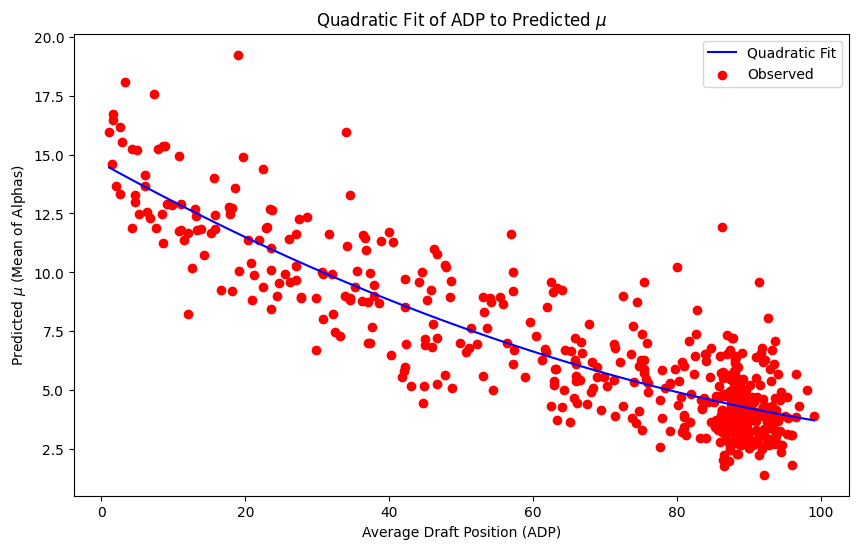

In [ ]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector<lower=0>[K] alpha;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model
  real beta1;  // linear coefficient for the quadratic model
  real beta2;  // quadratic coefficient for the quadratic model
  real<lower=0> sigma;  // standard deviation of the weekly scores
  real<lower=0> tau;  // standard deviation of the alpha's
}

transformed parameters {
  vector[K] mu; // overall mean of alphas
  for (k in 1:K) {
    mu[k] = beta0 + beta1 * adp[k] + beta2 * adp[k] * adp[k];
  }
}

model {
  // likelihood
  for (n in 1:N) {
    weekly_score[n] ~ normal(alpha[receiver[n]], sigma);
  }
  //
  alpha ~ normal(mu, tau);

  // Prior distributions
  beta0 ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  tau ~ normal(0, 10);
  sigma ~ normal(0, 10);
}
"""
def prepare_stan_data(df):
    # Ensure the player_year_id column is unique per player and season
    df['receiver_index'] = df['player_year_id'].astype('category').cat.codes + 1
    N = df.shape[0]
    K = df['receiver_index'].nunique()
    receiver = df['receiver_index'].values
    weekly_score = df['fantasy_points_half_ppr'].values
    adp = df.drop_duplicates(subset=['player_year_id'])[['receiver_index', 'avg_draft_position']].sort_values('receiver_index')['avg_draft_position'].values

    stan_data = {
        'N': N,
        'K': K,
        'receiver': receiver.tolist(),
        'weekly_score': weekly_score.tolist(),
        'adp': adp.tolist()
    }

    return stan_data

# Prepare the data
stan_data = prepare_stan_data(merged_data)

# Compile the Stan model
stan_model = stan.build(stan_model_code, data=stan_data)

# Fit the Stan model
fit = stan_model.sample(num_chains=1, num_samples=10)
#fit = stan_model.sample(num_chains=4, num_samples=2000)

# Print the summary of the fit
print(fit)

# Extract the samples for further analysis
samples = fit.to_frame()

# For example, to get the posterior means of beta coefficients
beta0_mean = samples['beta0'].mean()
beta1_mean = samples['beta1'].mean()
beta2_mean = samples['beta2'].mean()

print(f'Posterior means of beta coefficients: beta0 = {beta0_mean}, beta1 = {beta1_mean}, beta2 = {beta2_mean}')

beta0_mean = samples['beta0'].mean()
beta1_mean = samples['beta1'].mean()
beta2_mean = samples['beta2'].mean()

# Create a sequence of ADP values for the plot
adp_values = np.linspace(min(stan_data['adp']), max(stan_data['adp']), 100)

# Calculate the predicted mu for each ADP value
predicted_mu = beta0_mean + beta1_mean * adp_values + beta2_mean * adp_values**2

# Extract the mean of alphas for each receiver
# Ensure the number of alpha means matches the number of unique player_year_ids
alpha_columns = [col for col in samples.columns if col.startswith('alpha.')]
alpha_means = samples[alpha_columns].mean(axis=0).values

# Plot ADP vs predicted mu
plt.figure(figsize=(10, 6))
plt.plot(adp_values, predicted_mu, label='Quadratic Fit', color='blue')
plt.scatter(stan_data['adp'], alpha_means, color='red', label='Observed')

# Add labels and title
plt.xlabel('Average Draft Position (ADP)')
plt.ylabel('Predicted $\mu$ (Mean of Alphas)')
plt.title('Quadratic Fit of ADP to Predicted $\mu$')
plt.legend()

# Show the plot
plt.show()

In [ ]:
samples[['beta0', 'beta1', 'beta2', 'sigma', 'tau']].describe()

parameters,beta0,beta1,beta2,sigma,tau
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,14.629485,-0.168438,0.000589,5.615353,2.022295
std,0.512242,0.016724,0.000132,0.034473,0.053838
min,13.957357,-0.196951,0.000408,5.568395,1.928535
25%,14.243107,-0.179685,0.000487,5.585934,1.983316
50%,14.607854,-0.166704,0.000581,5.620232,2.030482
75%,14.982201,-0.154494,0.000659,5.629708,2.058383
max,15.393112,-0.145010,0.000840,5.669781,2.109444


In [ ]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector[K] loc;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model of mean
  real beta1;  // linear coefficient for the quadratic model of mean
  real beta2;  // quadratic coefficient for the quadratic report of mean
  real gamma0;  // intercept for scale
  real gamma1;  // coefficient for linear scale model
  real skew;
  real loc0;
  real loc1;
  real loc2;
  real<lower=0> tau;  // standard deviation of the alphas
}

transformed parameters {
  vector[K] mu = beta0 + beta1 * adp + beta2 * square(adp); // overall mean of alphas
  vector<lower=0>[K] omega = exp(gamma0 + gamma1 * loc);  // scale parameter
}

model {
  // Prior distributions
  beta0 ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  gamma0 ~ normal(0, 10);
  gamma1 ~ normal(0, 10);
  skew ~ normal(0, 10);
  loc0 ~ normal(0, 10);
  loc1 ~ normal(0, 10);
  loc2 ~ normal(0, 10);
  tau ~ normal(0, 10);

  loc ~ normal(mu, tau);
  weekly_score ~ skew_normal(loc[receiver], omega[receiver], skew);
}
"""

def prepare_stan_data(df):
    df['receiver_index'] = df['player_year_id'].astype('category').cat.codes + 1
    N = df.shape[0]
    K = df['receiver_index'].nunique()
    receiver = df['receiver_index'].values
    weekly_score = df['fantasy_points_half_ppr'].values
    adp = df.drop_duplicates(subset=['player_year_id'])[['receiver_index', 'avg_draft_position']].sort_values('receiver_index')['avg_draft_position'].values

    return {
        'N': N,
        'K': K,
        'receiver': receiver.tolist(),
        'weekly_score': weekly_score.tolist(),
        'adp': adp.tolist()
    }

stan_data = prepare_stan_data(merged_data)

stan_model = stan.build(stan_model_code, data=stan_data)
fit = stan_model.sample(num_chains=1, num_samples=100)

print(fit)

Building...



Building: 71.3s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1000/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.001806 seconds
  1000 transitions using 10 leapfrog steps per transition would take 18.06 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: skew_normal_lpdf: Scale parameter[181] is 0, but must be positive! (in '/tmp/httpstan_hpsksau2/model_iusjoelx.stan', line 43, colu

<stan.Fit>
Parameters:
    loc: (533,)
    beta0: ()
    beta1: ()
    beta2: ()
    gamma0: ()
    gamma1: ()
    skew: ()
    loc0: ()
    loc1: ()
    loc2: ()
    tau: ()
    mu: (533,)
    omega: (533,)
Draws: 100


In [ ]:
samples

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha.1,alpha.2,alpha.3,...,omega.524,omega.525,omega.526,omega.527,omega.528,omega.529,omega.530,omega.531,omega.532,omega.533
draws,,,,,,,,,,,,,,,,,,,,,
0,-12067.257578,0.593611,1.884324e-18,10.0,1023.0,0.0,12357.225290,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876
1,-12067.257578,0.892729,1.884324e-18,10.0,1023.0,0.0,12337.225030,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876
2,-12067.257578,0.624246,1.884324e-18,10.0,1023.0,0.0,12335.043365,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876
3,-12067.257578,0.658458,1.884324e-18,10.0,1023.0,0.0,12311.381341,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876
4,-12067.257578,0.263996,1.884324e-18,10.0,1023.0,0.0,12346.245125,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876
5,-12067.257578,0.953575,1.884324e-18,10.0,1023.0,0.0,12317.952327,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876
6,-12067.257578,0.864189,1.884324e-18,10.0,1023.0,0.0,12344.755259,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876
7,-12067.257578,0.634643,1.884324e-18,10.0,1023.0,0.0,12326.970906,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876
8,-12067.257578,0.992366,1.884324e-18,10.0,1023.0,0.0,12339.573920,2.547741,2.443943,1.881258,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,10.660843,9.688006,11.186079,9.680876


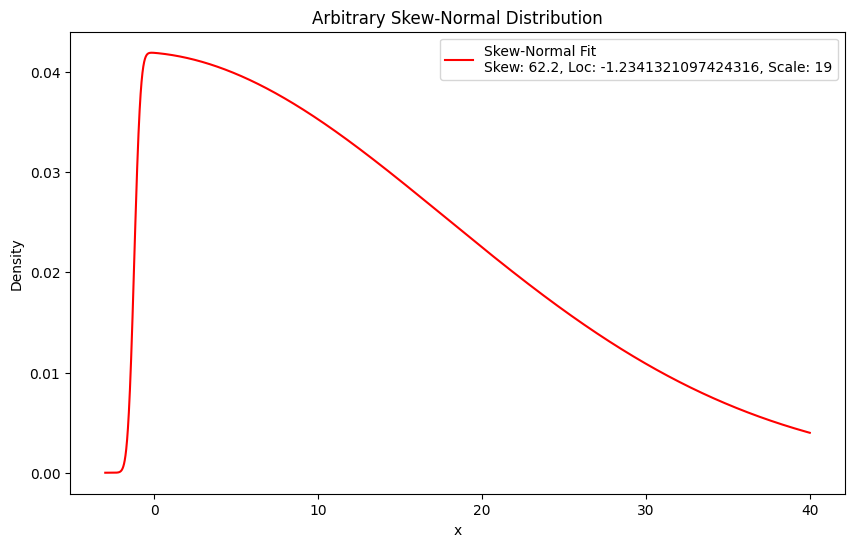

In [ ]:
def plot_skew_normal(alpha_skew, loc, scale, start=-3, end=40, num_points=10000):
    """
    Plots an arbitrary skew-normal distribution.

    Parameters:
    alpha_skew (float): Skewness parameter.
    loc (float): Location parameter (mean).
    scale (float): Scale parameter (standard deviation).
    start (float): Starting point of x-axis.
    end (float): Ending point of x-axis.
    num_points (int): Number of points to generate for the x-axis.
    """
    x = np.linspace(start, end, num_points)
    y = skewnorm.pdf(x, alpha_skew, loc=loc, scale=scale)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'Skew-Normal Fit\nSkew: {alpha_skew}, Loc: {loc}, Scale: {scale}', color='r')
    plt.title("Arbitrary Skew-Normal Distribution")
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Example usage
alpha_skew = 62.2
loc = -1.2341321097424316
scale = 19
plot_skew_normal(alpha_skew, loc, scale)

In [ ]:
def plot_fantasy_points_distribution(player_name, season, merged_data, fit):
    # Filter the data for the given player and season
    player_season_data = merged_data[(merged_data['player_display_name'] == player_name) & (merged_data['season'] == season)]

    if player_season_data.empty:
        print(f"No data found for {player_name} in the {season} season.")
        return

    # Extract receiver index for the player and season
    receiver_index = player_season_data['receiver_index'].unique()[0]

    # Debug: Print receiver index and check if it's within bounds
    print(f"Receiver index for {player_name} in {season}: {receiver_index}")

    # Extract the fitted parameters for the player
    alpha = fit['loc'][receiver_index - 1, :]  # 'alpha' is a matrix, extract the relevant column
    omega = fit['omega'][receiver_index - 1, :]
    alpha_skew = fit['skew'][:]
    print(alpha)
    # Debug: Print shapes of extracted parameter arrays
    print(f"Shape of alpha: {alpha.shape}")
    print(f"Shape of omega: {omega.shape}")
    print(f"Shape of alpha_skew: {alpha_skew.shape}")

    # Calculate the means of the extracted parameters
    alpha_mean = np.mean(alpha)
    omega_mean = np.mean(omega)
    skew_mean = np.mean(alpha_skew)
    print(alpha_mean)
    print(omega_mean)
    print(skew_mean)

    # Plot the fitted parameters
    # Generate the skew-normal distribution
    x = np.linspace(-10, 40, 1000)
    y = skewnorm.pdf(x, skew_mean, loc=alpha_mean, scale=omega_mean)

    # Plot the actual fantasy points and the skew-normal distribution
    plt.figure(figsize=(10, 6))
    plt.hist(player_season_data['fantasy_points_half_ppr'], bins=10, density=True, alpha=0.6, color='g', label='Actual Fantasy Points')
    plt.plot(x, y, label='Skew-Normal Fit', color='r')
    plt.title(f"{player_name}'s {season} Season Fantasy Points vs Skew-Normal Distribution Fit")
    plt.xlabel('Fantasy Points')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Example usage
player_name = 'Rashod Bateman'
season = 2023
plot_fantasy_points_distribution(player_name, season, merged_data, fit)

Receiver index for Rashod Bateman in 2023: 420


AssertionError: omega

In [ ]:
samples[['beta0', 'beta1', 'beta2', 'gamma0', 'gamma1', 'loc0', 'loc1', 'tau', 'skew']].describe()

parameters,beta0,beta1,beta2,gamma0,gamma1,loc0,loc1,tau,skew
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.288280,-0.006840,0.000039,8.868122,-0.425530,-1.077615,1.274168,1.728485,2.990674
std,0.006737,0.003748,0.000048,0.012613,0.006405,0.004796,0.010376,0.033957,0.006893
min,0.276760,-0.013255,-0.000024,8.849280,-0.441639,-1.084732,1.250472,1.698583,2.979125
25%,0.285642,-0.007868,0.000001,8.860576,-0.427217,-1.081503,1.269134,1.704756,2.987228
50%,0.290940,-0.005655,0.000022,8.867717,-0.422618,-1.076932,1.279186,1.717467,2.990834
75%,0.292960,-0.005452,0.000078,8.877927,-0.421961,-1.074321,1.280704,1.729221,2.995497
max,0.296240,-0.002475,0.000110,8.885449,-0.420290,-1.070928,1.283737,1.790370,3.001457


ValueError: x and y must be the same size

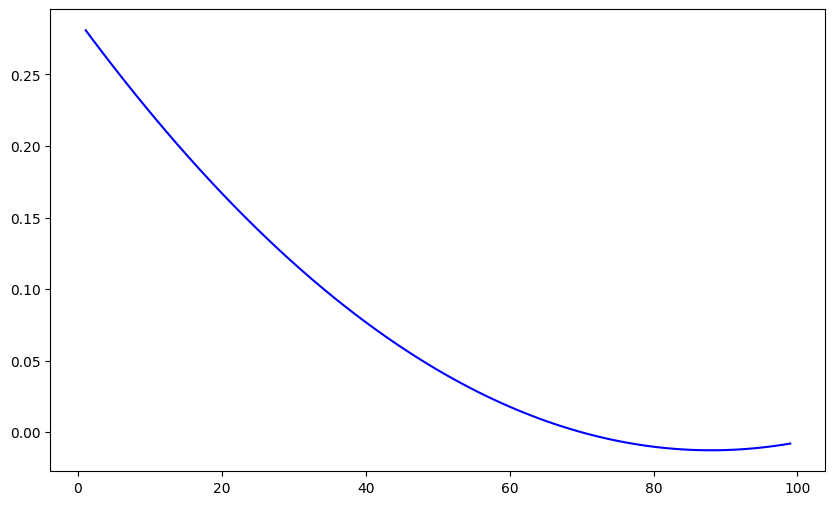

In [ ]:
samples = fit.to_frame()

beta0_mean = fit['beta0'].mean()
beta1_mean = fit['beta1'].mean()
beta2_mean = fit['beta2'].mean()

# Create a sequence of ADP values for the plot
adp_values = np.linspace(min(stan_data['adp']), max(stan_data['adp']), 100)

# Calculate the predicted mu for each ADP value
predicted_mu = beta0_mean + beta1_mean * adp_values + beta2_mean * adp_values**2

# Extract the mean of alphas for each receiver
# Ensure the number of alpha means matches the number of unique player_year_ids
alpha_columns = [col for col in samples.columns if col.startswith('alpha.')]
alpha_means = samples[alpha_columns].mean(axis=0).values

# Plot ADP vs predicted mu
plt.figure(figsize=(10, 6))
plt.plot(adp_values, predicted_mu, label='Quadratic Fit', color='blue')
plt.scatter(stan_data['adp'], alpha_means, color='red', label='Observed')

# Add labels and title
plt.xlabel('Average Draft Position (ADP)')
plt.ylabel('Predicted $\mu$ (Mean of Alphas)')
plt.title('Quadratic Fit of ADP to Predicted $\mu$')
plt.legend()

# Show the plot
plt.show()

In [ ]:
samples.describe()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha.1,alpha.2,alpha.3,...,omega.524,omega.525,omega.526,omega.527,omega.528,omega.529,omega.530,omega.531,omega.532,omega.533
count,10.000000,10.000000,1.000000e+01,10.0,10.0,10.0,10.000000,10.000000,1.000000e+01,1.000000e+01,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,10.000000
mean,-12067.257578,0.739658,1.884324e-18,10.0,1023.0,0.0,12333.622478,2.547741,2.443943e+00,1.881258e+00,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,1.066084e+01,9.688006e+00,11.186079,9.680876
std,0.000000,0.225873,0.000000e+00,0.0,0.0,0.0,14.394695,0.000000,4.681111e-16,4.681111e-16,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.872445e-15,1.872445e-15,0.000000,0.000000
min,-12067.257578,0.263996,1.884324e-18,10.0,1023.0,0.0,12311.381341,2.547741,2.443943e+00,1.881258e+00,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,1.066084e+01,9.688006e+00,11.186079,9.680876
25%,-12067.257578,0.626845,1.884324e-18,10.0,1023.0,0.0,12321.631886,2.547741,2.443943e+00,1.881258e+00,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,1.066084e+01,9.688006e+00,11.186079,9.680876
50%,-12067.257578,0.761324,1.884324e-18,10.0,1023.0,0.0,12336.134198,2.547741,2.443943e+00,1.881258e+00,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,1.066084e+01,9.688006e+00,11.186079,9.680876
75%,-12067.257578,0.912257,1.884324e-18,10.0,1023.0,0.0,12343.459924,2.547741,2.443943e+00,1.881258e+00,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,1.066084e+01,9.688006e+00,11.186079,9.680876
max,-12067.257578,0.992366,1.884324e-18,10.0,1023.0,0.0,12357.225290,2.547741,2.443943e+00,1.881258e+00,...,2.414953,5.671917,2.069916,6.143668,5.221472,0.880939,1.066084e+01,9.688006e+00,11.186079,9.680876


In [ ]:
beta0_mean = fit['beta0'].mean()
beta1_mean = fit['beta1'].mean()
beta2_mean = fit['beta2'].mean()
gamma0_mean = fit['gamma0'].mean()
gamma1_mean = fit['gamma1'].mean()

# Compute the parameters for ADP = 1
omega_adp1 = gamma0_mean + gamma1_mean * 3
alpha_skew_adp1 = delta0_mean + delta1_mean * 3

# Generate values for plotting the skew-normal distribution
x_values = np.linspace(-1, 40, 400)
pdf_values = skewnorm.pdf(x_values, skew_mean, loc=, scale=omega_adp1)

delta = alpha_skew_adp1 / np.sqrt(1 + alpha_skew_adp1**2)

# Calculate the mean of the skew-normal distribution
mean_skew_normal = 3 + omega_adp1 * delta * np.sqrt(2 / np.pi)
print(mean_skew_normal)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf_values, label='Skew-Normal Distribution')
plt.title(f'Skew-Normal Distribution for Alpha = 2')
plt.xlabel('Weekly Score')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

NameError: name 'delta0_mean' is not defined

#Disfunctional Gamma Model

In [ ]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector[K] loc;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model of mean
  real beta1;  // linear coefficient for the quadratic model of mean
  real beta2;  // quadratic coefficient for the quadratic model of mean
  real gamma0;  // intercept for scale
  real gamma1;  // coefficient for linear scale model
  real<lower=0> tau;  // standard deviation of the alphas
}

transformed parameters {
  vector[K] mu = beta0 + beta1 * adp + beta2 * square(adp); // overall mean of alphas
  vector<lower=0>[K] shape = exp(gamma0 + gamma1 * loc);  // shape parameter for Gamma
  vector<lower=0>[K] rate = shape ./ exp(loc);  // rate parameter for Gamma ensuring positivity
}

model {
  // Prior distributions
  beta0 ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  gamma0 ~ normal(0, 10);
  gamma1 ~ normal(0, 10);
  tau ~ normal(0, 10);

  loc ~ normal(mu, tau);
  weekly_score ~ gamma(shape[receiver], rate[receiver]);
}
"""

In [ ]:
def prepare_stan_data(df):
    # Replace negative or zero scores with a small positive number
    df['fantasy_points_half_ppr'] = df['fantasy_points_half_ppr'].apply(lambda x: max(x, 1e-6))

    # Create receiver_index based on player_year_id
    df['receiver_index'] = df['player_year_id'].astype('category').cat.codes + 1

    N = df.shape[0]
    K = df['receiver_index'].nunique()
    receiver = df['receiver_index'].values
    weekly_score = df['fantasy_points_half_ppr'].values
    adp = df.drop_duplicates(subset=['player_year_id'])[['receiver_index', 'avg_draft_position']].sort_values('receiver_index')['avg_draft_position'].values

    return {
        'N': N,
        'K': K,
        'receiver': receiver.tolist(),
        'weekly_score': weekly_score.tolist(),
        'adp': adp.tolist()
    }

# Example usage with the merged data
stan_data = prepare_stan_data(merged_data)

import stan

# Build and sample from the Stan model
stan_model = stan.build(stan_model_code, data=stan_data)
fit = stan_model.sample(num_chains=1, num_samples=10)

print(fit)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe [system:32]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: write: Broken pipe [system:32]
"""

The above exception was the direct cause of the following exception:

RuntimeError: write: Broken pipe [system:32]

Sampling:   0% (1/1010)ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=Runtime

<stan.Fit>
Parameters:
    loc: (533,)
    beta0: ()
    beta1: ()
    beta2: ()
    gamma0: ()
    gamma1: ()
    tau: ()
    mu: (533,)
    shape: (533,)
    rate: (533,)
Draws: 10


In [ ]:
from scipy.stats import gamma

Receiver index for Romeo Doubs in 2022: 429
loc: [1.27362445 1.40895462 1.63836364 1.65076874 1.4261642  1.3954362
 1.55920438 1.55523425 1.53230856 1.50787004]
shape: [0.25724513 0.32410287 0.51382173 0.5190477  0.34755706 0.31255723
 0.40457631 0.40893389 0.40463477 0.38560345]
rate: [0.0719812  0.0792103  0.09983439 0.09960646 0.08349316 0.07742823
 0.08508374 0.08634227 0.08741582 0.08536528]


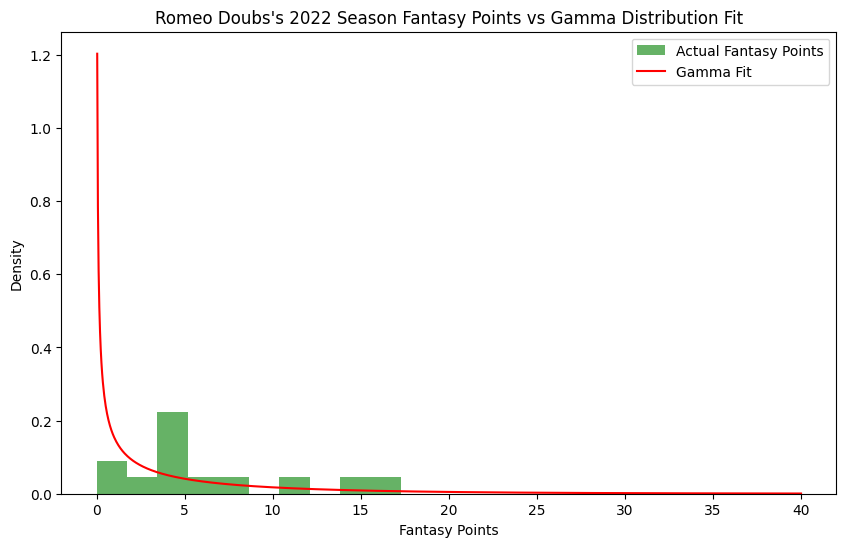

4.531733523132374


In [ ]:
def plot_fantasy_points_distribution(player_name, season, merged_data, fit):
    # Filter the data for the given player and season
    player_season_data = merged_data[(merged_data['player_display_name'] == player_name) & (merged_data['season'] == season)]

    if player_season_data.empty:
        print(f"No data found for {player_name} in the {season} season.")
        return

    # Extract receiver index for the player and season
    receiver_index = player_season_data['receiver_index'].unique()[0]

    # Debug: Print receiver index and check if it's within bounds
    print(f"Receiver index for {player_name} in {season}: {receiver_index}")

    # Extract the fitted parameters for the player
    loc = fit['loc'][receiver_index - 1, :]  # 'loc' is a vector, extract the relevant element
    shape = fit['shape'][receiver_index - 1, :]  # 'shape' is a vector, extract the relevant element
    rate = fit['rate'][receiver_index - 1, :]  # 'rate' is a vector, extract the relevant element

    # Debug: Print extracted parameter values
    print(f"loc: {loc}")
    print(f"shape: {shape}")
    print(f"rate: {rate}")
    loc = np.mean(loc)
    shape = np.mean(shape)
    rate = np.mean(rate)

    # Generate the Gamma distribution
    x = np.linspace(0, 40, 1000)
    y = gamma.pdf(x, a=shape, scale=1/rate)

    # Plot the actual fantasy points and the Gamma distribution
    plt.figure(figsize=(10, 6))
    plt.hist(player_season_data['fantasy_points_half_ppr'], bins=10, density=True, alpha=0.6, color='g', label='Actual Fantasy Points')
    plt.plot(x, y, label='Gamma Fit', color='r')
    plt.title(f"{player_name}'s {season} Season Fantasy Points vs Gamma Distribution Fit")
    plt.xlabel('Fantasy Points')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    print(shape * 1/rate)
# Example usage
player_name = 'Romeo Doubs'
season = 2022
plot_fantasy_points_distribution(player_name, season, merged_data, fit)

In [ ]:
samples = fit.to_frame()

In [ ]:
samples[['beta0', 'beta1', 'beta2', 'gamma0', 'gamma1']].describe()

parameters,beta0,beta1,beta2,gamma0,gamma1
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.617160,-0.013523,-0.000005,-3.853947,1.929649
std,0.038513,0.001289,0.000015,0.058909,0.031744
min,2.570293,-0.015221,-0.000031,-3.955194,1.869386
25%,2.593279,-0.014666,-0.000014,-3.887419,1.919954
50%,2.602969,-0.013362,-0.000003,-3.860771,1.926416
75%,2.649427,-0.012671,0.000004,-3.807060,1.940976
max,2.678999,-0.011451,0.000018,-3.771577,1.991052


#Zero-Spike + Gamma Model

In [ ]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position,player_year_id,position_index
0,Tom Brady,QB,2021,1,27.160000,10.484708,1,3
1,Tom Brady,QB,2021,2,29.639999,10.484708,1,3
2,Tom Brady,QB,2021,3,28.680000,10.484708,1,3
3,Tom Brady,QB,2021,4,11.060000,10.484708,1,3
4,Tom Brady,QB,2021,5,37.740002,10.484708,1,3
...,...,...,...,...,...,...,...,...
14716,Zach Charbonnet,RB,2023,14,5.300000,34.151697,1378,2
14717,Zach Charbonnet,RB,2023,15,1.600000,34.151697,1378,2
14718,Zach Charbonnet,RB,2023,16,0.100000,34.151697,1378,2
14719,Zach Charbonnet,RB,2023,17,6.600000,34.151697,1378,2


In [19]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> player;  // player index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each player
  array[K] int<lower=1, upper=4> pos; // position index for each player (1=WR, 2=RB, 3=QB, 4=TE)
}

parameters {
  vector<lower=0>[K] loc;  // individual means for each player
  vector[4] beta0;  // intercept for the quadratic model of mean, per position
  vector[4] beta1;  // linear coefficient for the quadratic model of mean, per position
  vector[4] beta2;  // quadratic coefficient for the quadratic model of mean, per position
  vector[4] gamma0;  // intercept for scale, per position
  vector[4] gamma1;  // coefficient for linear scale model, per position
  vector[4] gamma2;  // quadratic coefficient for scale model, per position
  vector[4] delta0;  // intercept for the bust prediction model, per position
  vector[4] delta1;  // coefficient for the bust prediction model, per position
  vector[4] delta2;  // quadratic coefficient for the bust prediction model, per position
  vector[4] tau0;  // intercept for tau, per position
  vector[4] tau1;  // linear coefficient for tau, per position
  vector[4] tau2;  // quadratic coefficient for tau, per position
}

transformed parameters {
  vector[K] mu_linpred;
  vector[K] rate;
  vector<lower=0>[K] shape;
  vector[N] bust_linpred;
  vector<lower=0>[K] tau;

  for (k in 1:K) {
    int p = pos[k];
    mu_linpred[k] = beta0[p] + beta1[p] * adp[k] + beta2[p] * square(adp[k]);
    rate[k] = exp(gamma0[p] + gamma1[p] * loc[k] + gamma2[p] * square(loc[k]));
    shape[k] = loc[k] * rate[k];
    tau[k] = exp(tau0[p] + tau1[p] * adp[k] + tau2[p] * square(adp[k]));
  }

  for (n in 1:N) {
    bust_linpred[n] = delta0[pos[player[n]]] + delta1[pos[player[n]]] * loc[player[n]] + delta2[pos[player[n]]] * square(loc[player[n]]);
  }
}

model {
  // Prior distributions
  for (p in 1:4) {
    beta0[p] ~ normal(15, 5);
    beta1[p] ~ normal(0, 5);
    beta2[p] ~ normal(0, 5);
    gamma0[p] ~ normal(0, 5);
    gamma1[p] ~ normal(0, 5);
    gamma2[p] ~ normal(0, 5);
    delta0[p] ~ normal(0, 5);
    delta1[p] ~ normal(0, 5);
    delta2[p] ~ normal(0, 5);
    tau0[p] ~ normal(0, 5);
    tau1[p] ~ normal(0, 5);
    tau2[p] ~ normal(0, 5);
  }
  loc ~ normal(mu_linpred, tau);

  // Likelihood
  for (n in 1:N) {
    if (weekly_score[n] == 0) {
      target += bernoulli_logit_lpmf(1 | bust_linpred[n]);
    } else {
      target += bernoulli_logit_lpmf(0 | bust_linpred[n]) +
                gamma_lpdf(weekly_score[n] | shape[player[n]], rate[player[n]]);
    }
  }
}
"""


In [ ]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> player;  // player index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each player
  array[K] int<lower=1, upper=4> pos; // position index for each player (1=WR, 2=RB, 3=QB, 4=TE)
}

parameters {
  vector<lower=0>[K] loc;  // individual means for each player
  vector<lower=0>[4] rate;  // rate parameters for each position
  vector[4] beta0;  // intercept for the quadratic model of mean, per position
  vector[4] beta1;  // linear coefficient for the quadratic model of mean, per position
  vector[4] beta2;  // quadratic coefficient for the quadratic model of mean, per position
  vector[4] delta0;  // intercept for the bust prediction model, per position
  vector[4] delta1;  // coefficient for the bust prediction model, per position
  vector[4] delta2;  // quadratic coefficient for the bust prediction model, per position
  vector<lower=0>[4] tau;  // variance for tau
}

transformed parameters {
  vector[K] mu_linpred;
  vector<lower=0, upper=1>[K] mu;
  vector<lower=0>[K] shape;
  vector[N] bust_linpred;

  for (k in 1:K) {
    int p = pos[k];
    mu_linpred[k] = beta0[p] + beta1[p] * adp[k] + beta2[p] * square(adp[k]);
    mu[k] = inv_logit(loc[k]);
    shape[k] = loc[k] / rate[p];
  }

  for (n in 1:N) {
    bust_linpred[n] = delta0[pos[player[n]]] + delta1[pos[player[n]]] * loc[player[n]] + delta2[pos[player[n]]] * square(loc[player[n]]);
  }
}

model {
  // Prior distributions
  for (p in 1:4) {
    beta0[p] ~ normal(15, 5);
    beta1[p] ~ normal(0, 5);
    beta2[p] ~ normal(0, 5);
    rate[p] ~ normal(0, 10);
    tau[p] ~ normal(0, 10);
    delta0[p] ~ normal(0, 5);
    delta1[p] ~ normal(0, 5);
    delta2[p] ~ normal(0, 5);
  }
  loc ~ normal(mu_linpred, tau[pos]);

  // Likelihood
  for (n in 1:N) {
    if (weekly_score[n] == 0) {
      target += bernoulli_logit_lpmf(1 | bust_linpred[n]);
    } else {
      target += bernoulli_logit_lpmf(0 | bust_linpred[n]) +
                gamma_lpdf(weekly_score[n] | shape[player[n]], rate[pos[player[n]]]);
    }
  }
}
"""

In [20]:
nest_asyncio.apply()

# Sample data preparation code (use your actual data)
# Assume data contains columns: player_name, position_name, year, position_pick_number, player_display_name, position, season, week, fantasy_points_half_ppr

data['avg_draft_position'] = data.groupby(['year', 'player_name'])['position_pick_number'].transform('mean')
data = data[['player_name', 'position_name', 'year', 'avg_draft_position']].drop_duplicates()
merged_data = pd.merge(nfl_data, data, how='inner',
                       left_on=['player_display_name', 'position', 'season'],
                       right_on=['player_name', 'position_name', 'year'])

merged_data = merged_data[['player_display_name', 'position', 'season', 'week', 'fantasy_points_half_ppr', 'avg_draft_position']]
merged_data = merged_data[merged_data['position'] != 'FB']
merged_data['player_year_id'] = pd.factorize(merged_data['player_display_name'].astype(str) + '_' + merged_data['season'].astype(str))[0] + 1  # Ensure 1-indexing for Stan

In [ ]:
def prepare_stan_data(df):
    df['fantasy_points_half_ppr'] = df['fantasy_points_half_ppr'].apply(lambda x: max(x, 0))
    position_map = {'WR': 1, 'RB': 2, 'QB': 3, 'TE': 4}
    df['position_index'] = df['position'].map(position_map)

    N = df.shape[0]
    K = df['player_year_id'].nunique()
    player = df['player_year_id'].values
    weekly_score = df['fantasy_points_half_ppr'].values
    adp = df.drop_duplicates(subset=['player_year_id'])[['player_year_id', 'avg_draft_position']].sort_values('player_year_id')['avg_draft_position'].values
    pos = df.drop_duplicates(subset=['player_year_id'])[['player_year_id', 'position_index']].sort_values('player_year_id')['position_index'].values

    return {
        'N': N,
        'K': K,
        'player': player.tolist(),
        'weekly_score': weekly_score.tolist(),
        'adp': adp.tolist(),
        'pos': pos.tolist()
    }

stan_data = prepare_stan_data(merged_data)

stan_model = stan.build(stan_model_code, data=stan_data)

init_values = [
    {'beta0': [16, 16, 16, 16], 'beta1': [-0.15, -0.15, -0.15, -0.15], 'beta2': [0, 0, 0, 0],
     'gamma0': [0, 0, 0, 0], 'gamma1': [0, 0, 0, 0], 'gamma2': [0, 0, 0, 0],
     'delta0': [0.5, 0.5, 0.5, 0.5], 'delta1': [-0.5, -0.5, -0.5, -0.5], 'delta2': [0, 0, 0, 0],
     'tau0': [0, 0, 0, 0], 'tau1': [0, 0, 0, 0], 'tau2': [0, 0, 0, 0]}
] * 4
fit = stan_model.sample(num_chains=4, num_samples=500, num_warmup=500, init=init_values)

print(fit)

Building...



Building: 76.6s, done.Messages from stanc:
Warning in '/tmp/httpstan_lofa6rwg/model_3txpmb5q.stan', line 50, column 22: Argument
    15 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)

In [ ]:
samples_df = fit.to_frame()

# Save the DataFrame to a CSV file in the Colab environment
csv_path = 'stan_samples.csv'
samples_df.to_csv(csv_path, index=False)

# Use Colab's file download utility
from google.colab import files
files.download(csv_path)
print("Samples have been saved and downloaded as stan_samples.csv")

In [ ]:
samples.describe()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,loc.1,loc.2,loc.3,...,tau.1352,tau.1353,tau.1354,tau.1355,tau.1356,tau.1357,tau.1358,tau.1359,tau.1360,tau.1361
count,40.000000,40.0,40.00000,40.0,40.0,40.0,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,-163529.541656,0.0,0.05796,0.0,1.0,1.0,164235.597516,2.178876,1.080650,0.568997,...,4.255440,2.465560,1.032640,1.069058,2.783973,1.053057,1.079338,1.062000,1.011310,1.320764
std,2353.731645,0.0,0.00000,0.0,0.0,0.0,2356.354481,1.905118,0.671598,0.220803,...,0.054242,0.085366,0.001270,0.002828,0.025088,0.003319,0.005019,0.003893,0.000698,0.014041
min,-166279.737999,0.0,0.05796,0.0,1.0,1.0,160843.401952,0.284537,0.395019,0.265993,...,4.210247,2.389538,1.031491,1.066184,2.763130,1.048089,1.071851,1.056181,1.010246,1.308187
25%,-165315.544736,0.0,0.05796,0.0,1.0,1.0,162717.975481,0.304416,0.584317,0.411705,...,4.212974,2.389929,1.031522,1.067409,2.764355,1.051888,1.077546,1.060621,1.011087,1.308306
50%,-163822.073876,0.0,0.05796,0.0,1.0,1.0,164544.517567,2.176479,0.899987,0.602776,...,4.234150,2.439562,1.032263,1.068196,2.774078,1.053428,1.079871,1.062426,1.011410,1.316559
75%,-162036.070795,0.0,0.05796,0.0,1.0,1.0,166035.610287,4.050939,1.396320,0.760069,...,4.276616,2.515192,1.033381,1.069845,2.793696,1.054597,1.081664,1.063806,1.011634,1.329017
max,-160194.280872,0.0,0.05796,0.0,1.0,1.0,167035.980675,4.078009,2.127608,0.804442,...,4.343214,2.593578,1.034542,1.073658,2.824605,1.057284,1.085759,1.066968,1.012174,1.341752


In [ ]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector<lower=0>[K] loc;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model of mean
  real beta1;  // linear coefficient for the quadratic model of mean
  real beta2;  // quadratic coefficient for the quadratic model of mean
  real gamma0;  // intercept for scale
  real gamma1;  // coefficient for linear scale model
  real gamma2;
  real delta0;  // intercept for the bust prediction model
  real delta1;  // coefficient for the bust prediction model
  real delta2;
  real tau0;
  real tau1;
  real tau2;
}

transformed parameters {
  vector[K] mu_linpred = beta0 + beta1 * adp + beta2 * square(adp); // linear predictor for mean
  vector[K] rate = exp(gamma0 + gamma1 * loc + gamma2 * square(loc));  // rate parameter for Gamma
  vector<lower=0>[K] shape = loc .* rate;  // shape parameter for Gamma, α = μ × β
  vector[N] bust_linpred = delta0 + delta1 * loc[receiver] + delta2 * square(loc[receiver]);  // linear predictor for bust probability
  vector<lower=0>[K] tau = exp(tau0 + tau1 * adp + tau2 * square(adp));  // standard deviation of the alphas
  print("After Transformed Parameters");
}
model {
  // Prior distributions
  beta0 ~ normal(16, 5);
  beta1 ~ normal(-0.15, 5);
  beta2 ~ normal(0, 5);
  gamma0 ~ normal(-1, 5);
  gamma1 ~ normal(0, 5);
  gamma2 ~ normal(0, 5);
  delta0 ~ normal(0.5, 5);
  delta1 ~ normal(-0.5, 5);
  delta2 ~ normal(0, 5);
  tau0 ~ normal(0, 5);
  tau1 ~ normal(0, 5);
  tau2 ~ normal(0, 4);
  loc ~ normal(mu_linpred, tau);
  print("After Priors 1");
  // Likelihood
  for (n in 1:N) {
    // Bust prediction
    weekly_score[n] == 0 ~ bernoulli_logit(bust_linpred[n]);

    if (weekly_score[n] > 0) {  // not a bust, Gamma distributed scores
      weekly_score[n] ~ gamma(shape[receiver[n]], rate[receiver[n]]);
    }
  }
  print("After Likelihood");
}
"""

In [ ]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector<lower=0>[K] loc;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model of mean
  real beta1;  // linear coefficient for the quadratic model of mean
  real beta2;  // quadratic coefficient for the quadratic model of mean
  real gamma0;  // intercept for scale
  real gamma1;  // coefficient for linear scale model
  real gamma2;
  real delta0;  // intercept for the bust prediction model
  real delta1;  // coefficient for the bust prediction model
  real delta2;
  real tau0;
  real tau1;
  real tau2;
}

transformed parameters {
  vector[K] mu_linpred = beta0 + beta1 * adp + beta2 * square(adp);  // linear predictor for mean
  vector[K] rate = exp(gamma0 + gamma1 * loc + gamma2 * square(loc));  // rate parameter for Gamma
  vector<lower=0>[K] shape = loc .* rate;  // shape parameter for Gamma, α = μ × β
  vector[N] bust_linpred = delta0 + delta1 * loc[receiver] + delta2 * square(loc[receiver]);  // linear predictor for bust probability
  vector<lower=0>[K] tau = exp(tau0 + tau1 * adp + tau2 * square(adp));  // standard deviation of the alphas
}

model {
  // Prior distributions
  beta0 ~ normal(16, 5);
  beta1 ~ normal(-0.15, 5);
  beta2 ~ normal(0, 5);
  gamma0 ~ normal(-1, 5);
  gamma1 ~ normal(0, 5);
  gamma2 ~ normal(0, 5);
  delta0 ~ normal(0.5, 5);
  delta1 ~ normal(-0.5, 5);
  delta2 ~ normal(0, 5);
  tau0 ~ normal(0, 5);
  tau1 ~ normal(0, 5);
  tau2 ~ normal(0, 5);
  loc ~ normal(mu_linpred, tau);

  // Likelihood
  for (n in 1:N) {
    if (weekly_score[n] == 0) {
      target += bernoulli_logit_lpmf(1 | bust_linpred[n]);
    } else {
      target += bernoulli_logit_lpmf(0 | bust_linpred[n]) +
                gamma_lpdf(weekly_score[n] | shape[receiver[n]], rate[receiver[n]]);
    }
  }
}
"""


In [ ]:
nest_asyncio.apply()
data['avg_draft_position'] = data.groupby(['year', 'player_name'])['position_pick_number'].transform('mean')
data = data[['player_name', 'position_name', 'year', 'avg_draft_position']].drop_duplicates()
merged_data = pd.merge(nfl_data, data, how='inner',
                       left_on=['player_display_name', 'position', 'season'],
                       right_on=['player_name', 'position_name', 'year'])

merged_data = merged_data[['player_display_name', 'position', 'season', 'week', 'fantasy_points_half_ppr', 'avg_draft_position']]

merged_data['player_year_id'] = pd.factorize(merged_data['player_display_name'].astype(str) + '_' + merged_data['season'].astype(str))[0] + 1  # Ensure 1-indexing for Stan
merged_data = merged_data[merged_data['position'] == 'WR']
merged_data['player_year_id'] = merged_data.groupby(['player_display_name', 'season']).ngroup() + 1

In [ ]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position,player_year_id
72,Danny Amendola,WR,2021,1,11.900000,88.000000,120
73,Danny Amendola,WR,2021,2,1.400000,88.000000,120
74,Danny Amendola,WR,2021,7,3.200000,88.000000,120
75,Danny Amendola,WR,2021,8,1.300000,88.000000,120
76,Danny Amendola,WR,2021,9,6.400000,88.000000,120
...,...,...,...,...,...,...,...
14654,Jayden Reed,WR,2023,15,14.200001,72.504599,264
14655,Jayden Reed,WR,2023,17,23.900000,72.504599,264
14656,Jayden Reed,WR,2023,18,13.200000,72.504599,264
14657,Jayden Reed,WR,2023,19,0.000000,72.504599,264


In [ ]:
def prepare_stan_data(df):
    df['fantasy_points_half_ppr'] = df['fantasy_points_half_ppr'].apply(lambda x: max(x, 0))
    df['receiver_index'] = df['player_year_id'].astype('category').cat.codes + 1

    N = df.shape[0]
    K = df['receiver_index'].nunique()
    receiver = df['receiver_index'].values
    weekly_score = df['fantasy_points_half_ppr'].values
    adp = df.drop_duplicates(subset=['player_year_id'])[['receiver_index', 'avg_draft_position']].sort_values('receiver_index')['avg_draft_position'].values

    return {
        'N': N,
        'K': K,
        'receiver': receiver.tolist(),
        'weekly_score': weekly_score.tolist(),
        'adp': adp.tolist()
    }

stan_data = prepare_stan_data(merged_data)

stan_model = stan.build(stan_model_code, data=stan_data)
init_values = [
    {'beta0': 16, 'beta1': -0.15, 'beta2': 0, 'gamma0': -1, 'gamma1': 0, 'gamma2': 0,
     'delta0': 0.5, 'delta1': -0.5, 'delta2': 0, 'tau0': 0, 'tau1': 0, 'tau2': 0}
] * 4  # one set of initial values per chain

fit = stan_model.sample(num_chains=4, num_samples=1000, init=init_values)

print(fit)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_7bvdvxlm/model_ltknbjbo.stan', line 36, column 17: Argument
    16 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  13% (1001/8000)
Sampling:  14% (1100/8000)
Sampling:  14% (1101/8000)
Sampling:  15% (1201/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/

<stan.Fit>
Parameters:
    loc: (533,)
    beta0: ()
    beta1: ()
    beta2: ()
    gamma0: ()
    gamma1: ()
    gamma2: ()
    delta0: ()
    delta1: ()
    delta2: ()
    tau0: ()
    tau1: ()
    tau2: ()
    mu_linpred: (533,)
    rate: (533,)
    shape: (533,)
    bust_linpred: (6033,)
    tau: (533,)
Draws: 4000


In [ ]:
fit

In [ ]:
from scipy.stats import ks_2samp

In [ ]:
fit.describe()

AttributeError: 'Fit' object has no attribute 'describe'

In [ ]:
samples = fit.to_frame()

In [ ]:
samples[['beta0', 'beta1', 'beta2', 'gamma0', 'gamma1', 'gamma2', 'delta0', 'delta1', 'delta2', 'tau0', 'tau1', 'tau2']].describe()

(array([0.02783118, 0.02783118, 0.        , 0.        , 0.02783118,
        0.02783118, 0.        , 0.05566236, 0.02783118, 0.02783118,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.16698707, 0.08349354, 0.11132471, 0.05566236, 0.02783118,
        0.19481825, 0.16698707, 0.13915589, 0.47313003, 0.33397414,
        0.27831179, 0.41746768, 0.3896365 , 0.47313003, 0.3896365 ,
        0.50096121, 0.47313003, 0.52879239, 0.47313003, 0.47313003,
        0.25048061, 0.27831179, 0.66794828, 0.19481825, 0.55662357,
        0.33397414, 0.27831179, 0.52879239, 0.33397414, 0.41746768,
        0.33397414, 0.33397414, 0.27831179, 0.33397414, 0.22264943,
        0.30614296, 0.30614296, 0.58445475, 0.44529886, 0.3896365 ,
        0.50096121, 0.61228593, 0.52879239, 0.47313003, 0.52879239,
        0.52879239, 0.66794828, 0.55662357, 0.52879239, 0.36180532,
        0.30614296, 0.33397414, 0.44529886, 0.27831179, 0.22264943,
        0.27831179, 0.05566236, 0.11132471, 0.11

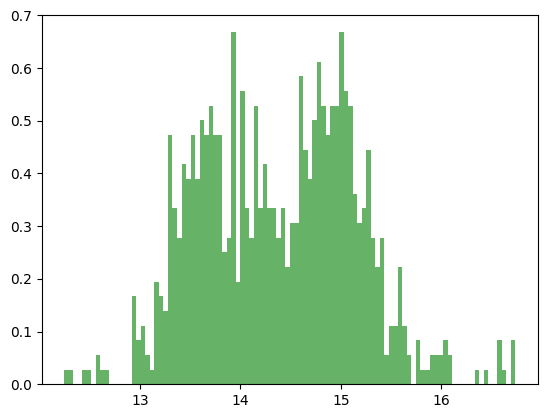

In [ ]:
plt.hist(samples['beta0'], bins=100, density=True, alpha=0.6, color='g', label='beta0')

In [ ]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position,player_year_id,receiver_index
72,Danny Amendola,WR,2021,1,11.900000,88.000000,120,120
73,Danny Amendola,WR,2021,2,1.400000,88.000000,120,120
74,Danny Amendola,WR,2021,7,3.200000,88.000000,120,120
75,Danny Amendola,WR,2021,8,1.300000,88.000000,120,120
76,Danny Amendola,WR,2021,9,6.400000,88.000000,120,120
...,...,...,...,...,...,...,...,...
14654,Jayden Reed,WR,2023,15,14.200001,72.504599,264,264
14655,Jayden Reed,WR,2023,17,23.900000,72.504599,264,264
14656,Jayden Reed,WR,2023,18,13.200000,72.504599,264,264
14657,Jayden Reed,WR,2023,19,0.000000,72.504599,264,264


In [ ]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position,player_year_id,receiver_index,bust_prob,mean_bust_linpred
0,Danny Amendola,WR,2021,1,11.900000,88.000000,120,120,0.123925,-3.709433
1,Danny Amendola,WR,2021,2,1.400000,88.000000,120,120,0.123925,-3.709433
2,Danny Amendola,WR,2021,7,3.200000,88.000000,120,120,0.123925,-3.709433
3,Danny Amendola,WR,2021,8,1.300000,88.000000,120,120,0.123925,-3.709433
4,Danny Amendola,WR,2021,9,6.400000,88.000000,120,120,0.123925,-3.709433
...,...,...,...,...,...,...,...,...,...,...
6028,Jayden Reed,WR,2023,15,14.200001,72.504599,264,264,0.024821,-4.065270
6029,Jayden Reed,WR,2023,17,23.900000,72.504599,264,264,0.024821,-4.065270
6030,Jayden Reed,WR,2023,18,13.200000,72.504599,264,264,0.024821,-4.065270
6031,Jayden Reed,WR,2023,19,0.000000,72.504599,264,264,0.024821,-4.065270


player_display_name    Cooper Kupp
season                        2021
mean_loc                 17.762363
Name: 99, dtype: object
player_display_name    Tyreek Hill
season                        2023
mean_loc                 16.792296
Name: 511, dtype: object
player_display_name    CeeDee Lamb
season                        2023
mean_loc                 16.447513
Name: 70, dtype: object
player_display_name    Cooper Kupp
season                        2022
mean_loc                 16.035371
Name: 100, dtype: object
player_display_name    Davante Adams
season                          2021
mean_loc                   15.980827
Name: 129, dtype: object
player_display_name    Justin Jefferson
season                             2022
mean_loc                      15.849794
Name: 288, dtype: object
player_display_name    Davante Adams
season                          2022
mean_loc                   15.587987
Name: 130, dtype: object
player_display_name    Justin Jefferson
season                   

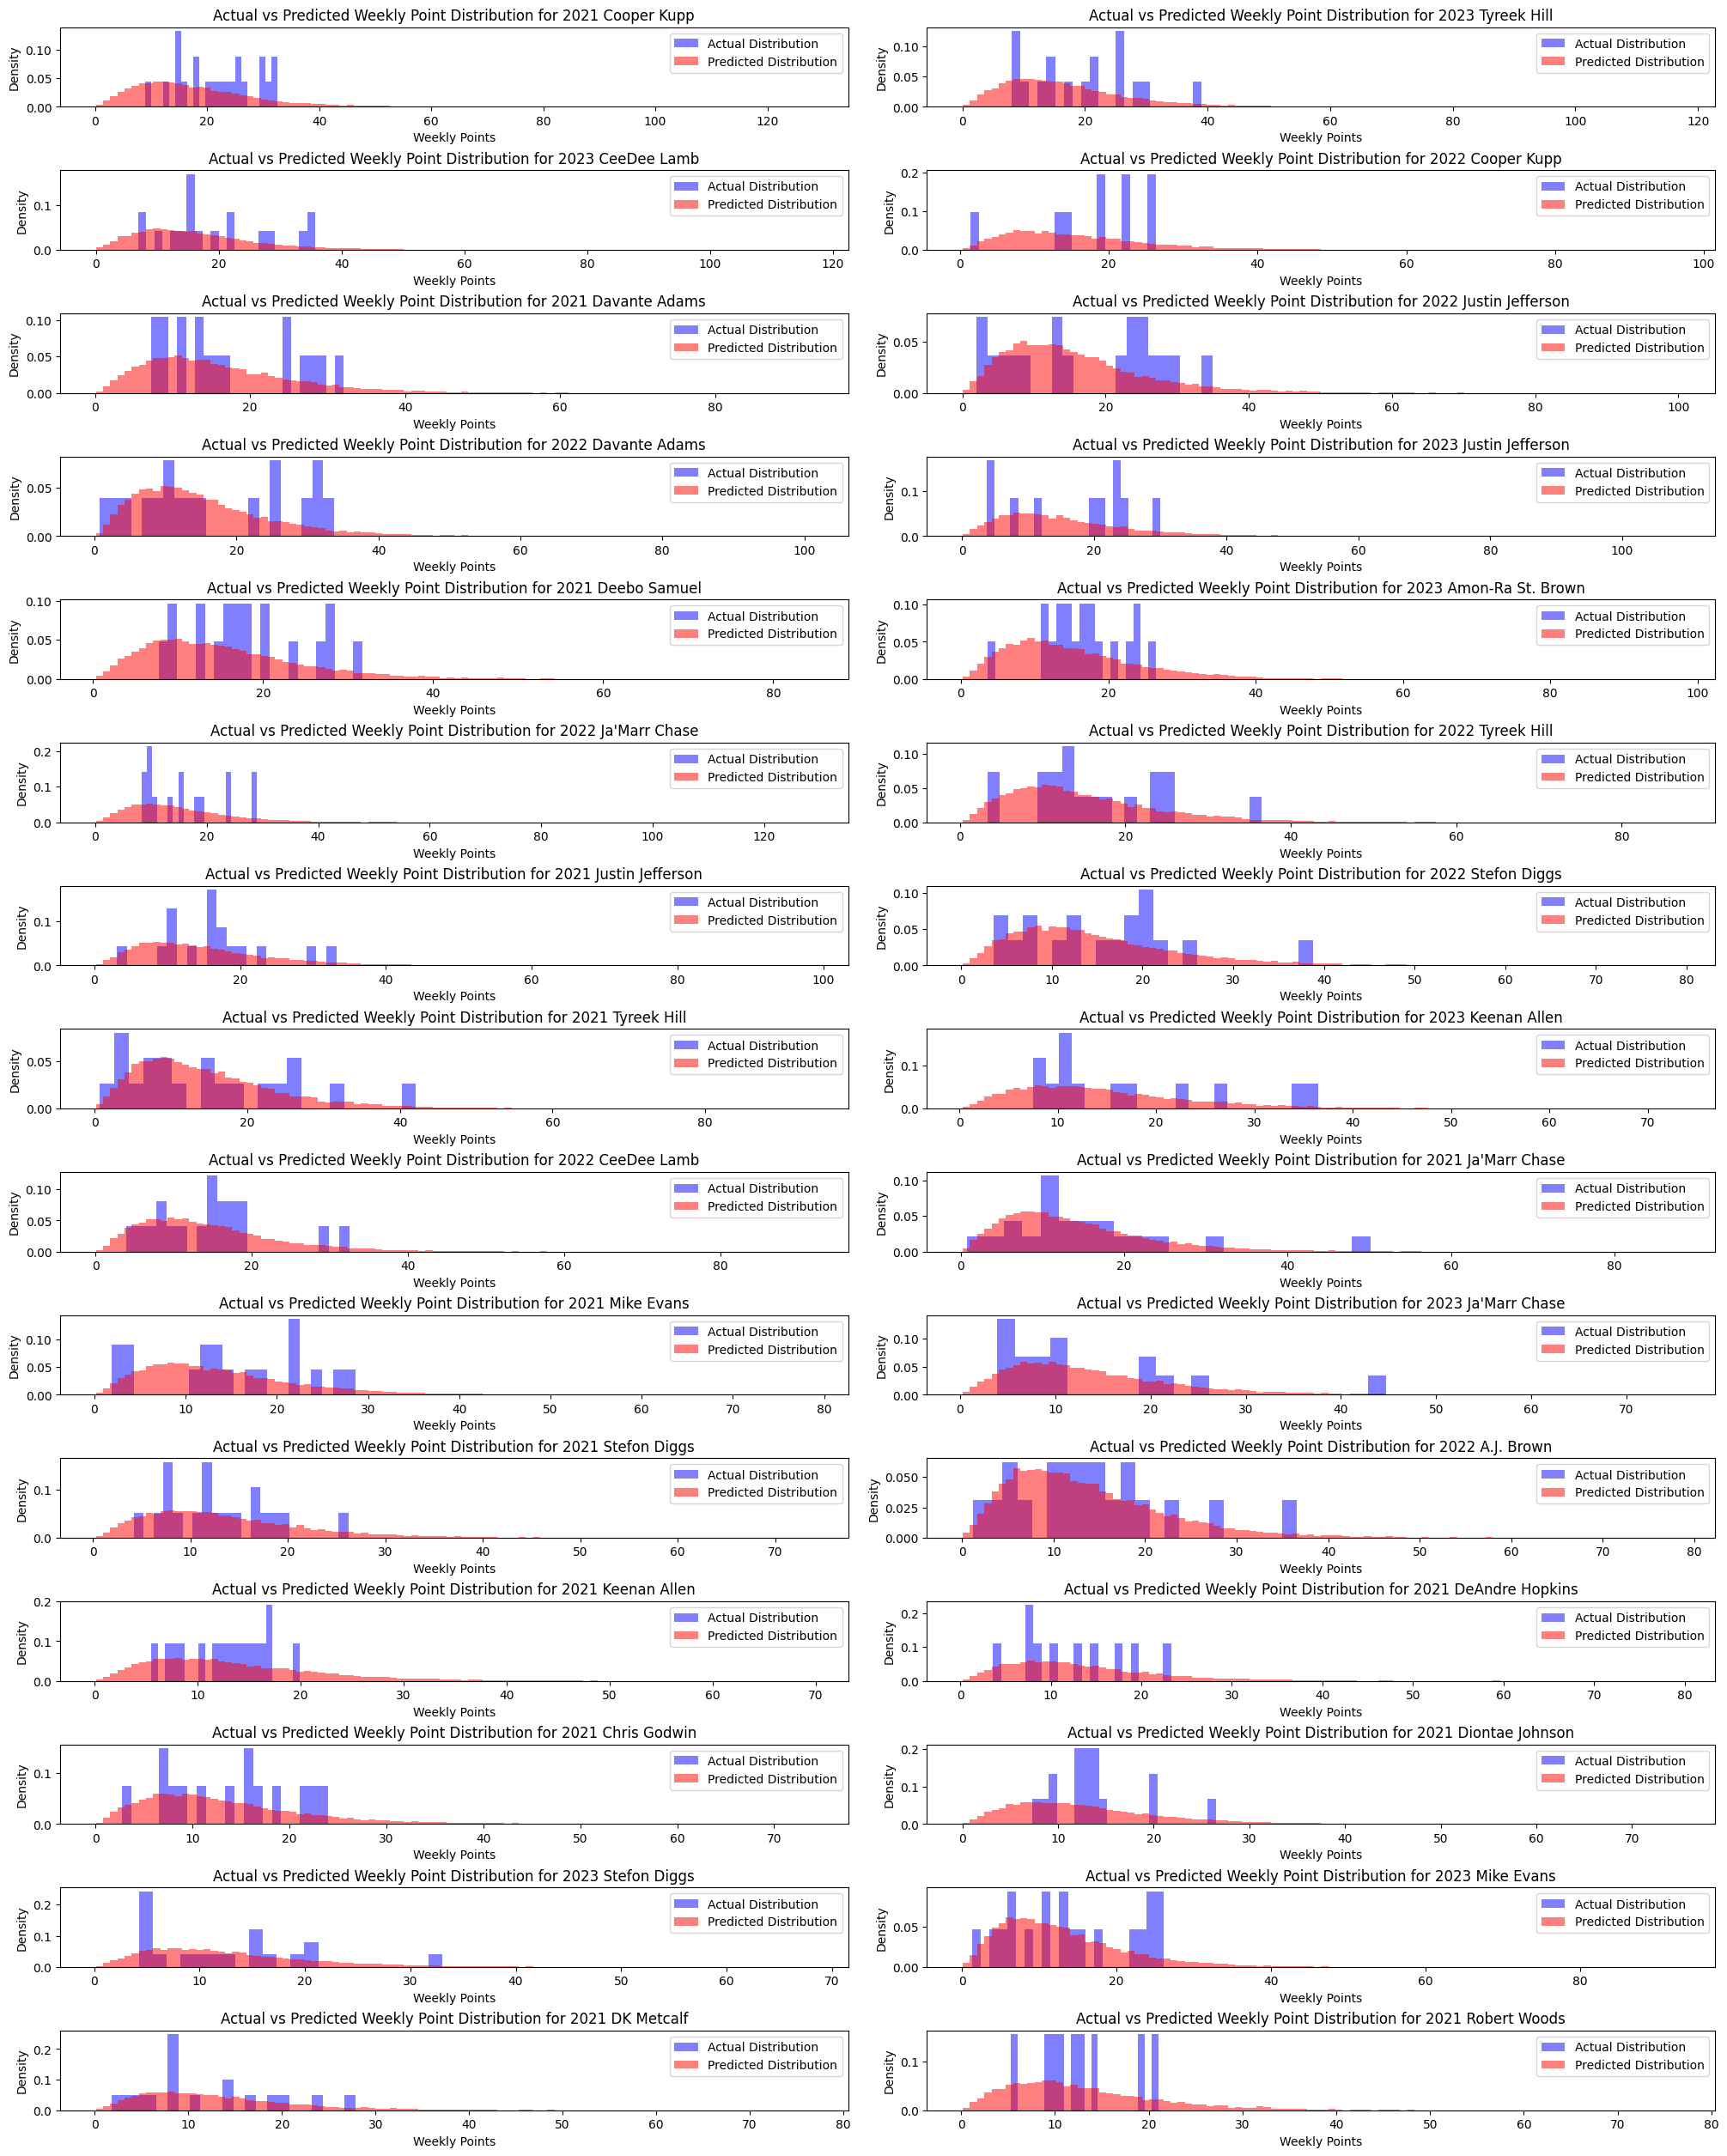

In [ ]:
mean_loc_values = merged_data.groupby(['player_display_name', 'season']).apply(
    lambda x: np.mean(fit['loc'][x['receiver_index'].iloc[0] - 1, :])
).reset_index()
mean_loc_values.columns = ['player_display_name', 'season', 'mean_loc']

# Get the top 30 player-season combinations based on mean 'loc' values
top_30_player_seasons = mean_loc_values.nlargest(30, 'mean_loc')

fig, axs = plt.subplots(15, 2, figsize=(20, 25), constrained_layout=True)

for plot_idx, (_, row) in enumerate(top_30_player_seasons.iterrows()):
    player = row['player_display_name']
    season = row['season']
    print(row)
    # Extract the unique receiver_index for the player-season combination
    receiver_index = merged_data.loc[
        (merged_data['player_display_name'] == player) & (merged_data['season'] == season),
        'receiver_index'
    ].iloc[0]

    # Use the receiver_index to select the corresponding player data
    player_data = merged_data[merged_data['receiver_index'] == receiver_index]

    # Use the precomputed mean bust probabilities from the merged data
    bust_probabilities = 1 / (1 + np.exp(-player_data['mean_bust_linpred'].iloc[0]))

    # Use mean parameters for simulation
    receiver_idx = receiver_index - 1  # Adjust for zero-indexing in Python
    loc_samples = fit['loc'][receiver_idx, :]
    shape_samples = fit['shape'][receiver_idx, :]
    rate_samples = fit['rate'][receiver_idx, :]

    # Generate predicted weekly scores
    predicted_scores = []
    for i in range(800):  # Number of Monte Carlo samples
        weekly_scores = []
        for j in range(len(player_data)):
            if 2 < bust_probabilities:
                weekly_scores.append(0)
            else:
                weekly_scores.append(np.random.gamma(shape_samples[i], 1 / rate_samples[i]))
        predicted_scores.append(weekly_scores)

    predicted_scores = np.array(predicted_scores).flatten()
    actual_scores = player_data['fantasy_points_half_ppr'].values

    row_idx, col_idx = divmod(plot_idx, 2)
    axs[row_idx, col_idx].hist(actual_scores, bins=22, alpha=0.5, color='blue', label='Actual Distribution', density=True)
    axs[row_idx, col_idx].hist(predicted_scores, bins=100, alpha=0.5, color='red', label='Predicted Distribution', density=True)

    axs[row_idx, col_idx].set_title(f'Actual vs Predicted Weekly Point Distribution for {season} {player}')
    axs[row_idx, col_idx].set_xlabel('Weekly Points')
    axs[row_idx, col_idx].set_ylabel('Density')
    axs[row_idx, col_idx].legend()

plt.show()

In [ ]:
ceedee_lamb_data = merged_data[(merged_data['player_display_name'] == 'Tank Dell') & (merged_data['season'] == 2023)]

460
(533, 800)
9.309590639942105
[0.17134207 0.1386066  0.15995371 0.13735085 0.1930735  0.14168459
 0.12744911 0.20560524 0.20238181 0.13409305 0.15390398 0.14777859
 0.19991955 0.14002888 0.12871003 0.19834603 0.21488731 0.14816831
 0.14217559 0.15903113 0.20674733 0.18503031 0.14469597 0.13040316
 0.2166342  0.18444115 0.15337962 0.18042509 0.19850615 0.18440755
 0.19019386 0.11875267 0.20030476 0.17448582 0.11413467 0.20673408
 0.23604423 0.16665087 0.20983642 0.10114472 0.20553909 0.18187046
 0.18943885 0.12326165 0.23261708 0.1671433  0.09359792 0.21707732
 0.18042049 0.1825354  0.07722963 0.08545631 0.20109152 0.18158332
 0.18618735 0.14724401 0.19278963 0.19589251 0.16712662 0.18341624
 0.19251216 0.200816   0.11486774 0.18988861 0.19237542 0.16054733
 0.17401095 0.13389112 0.1882269  0.16791007 0.15971577 0.18243897
 0.18310515 0.18705    0.16169725 0.18008194 0.21300482 0.14685459
 0.20186547 0.14590801 0.20302714 0.10971111 0.1731639  0.11105357
 0.2036993  0.10896523 0.1161

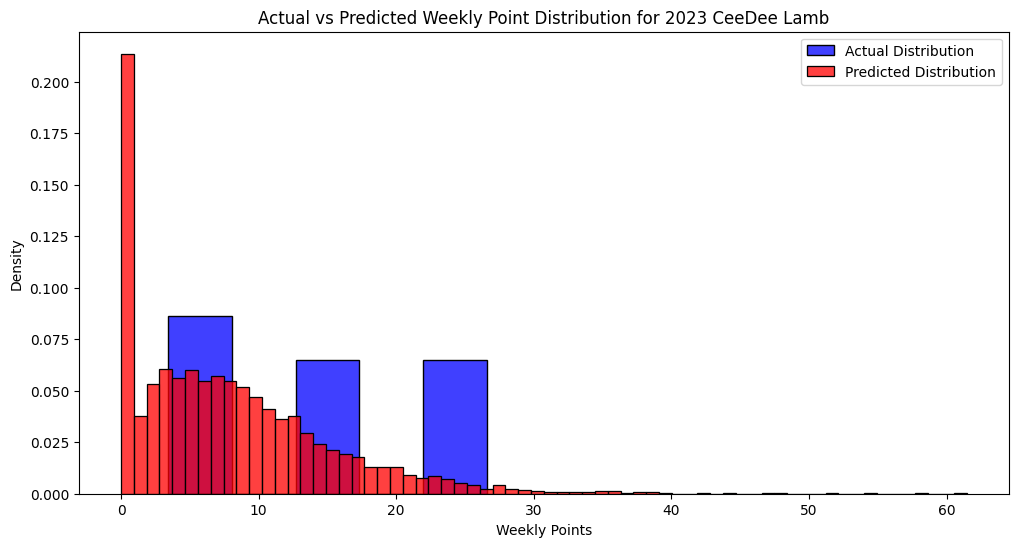

In [ ]:
receiver_index = ceedee_lamb_data['receiver_index'].iloc[0] - 1
print(receiver_index)
print(np.shape(fit['loc']))
loc_samples = fit['loc'][receiver_index, :]
shape_samples = fit['shape'][receiver_index, :]
print(np.mean(loc_samples))
rate_samples = fit['rate'][receiver_index, :]
bust_linpred_samples = fit['bust_linpred'][receiver_index, :]

# Calculate bust probabilities
bust_probabilities = 1 / (1 + np.exp(-bust_linpred_samples))
print(bust_probabilities)
# Generate predicted weekly scores
predicted_scores = []
for i in range(800):
    weekly_scores = []
    for j in range(len(ceedee_lamb_data)):
        if np.random.rand() < bust_probabilities[i]:
            weekly_scores.append(0)
        else:
            weekly_scores.append(np.random.gamma(shape_samples[i], 1 / rate_samples[i]))
    predicted_scores.append(weekly_scores)

predicted_scores = np.array(predicted_scores).flatten()
actual_scores = ceedee_lamb_data['fantasy_points_half_ppr']

plt.figure(figsize=(12, 6))

sns.histplot(actual_scores, color='blue', label='Actual Distribution', stat='density')
sns.histplot(predicted_scores, color='red', label='Predicted Distribution', stat='density')

plt.title('Actual vs Predicted Weekly Point Distribution for 2023 CeeDee Lamb')
plt.xlabel('Weekly Points')
plt.ylabel('Density')
plt.legend()
plt.show()

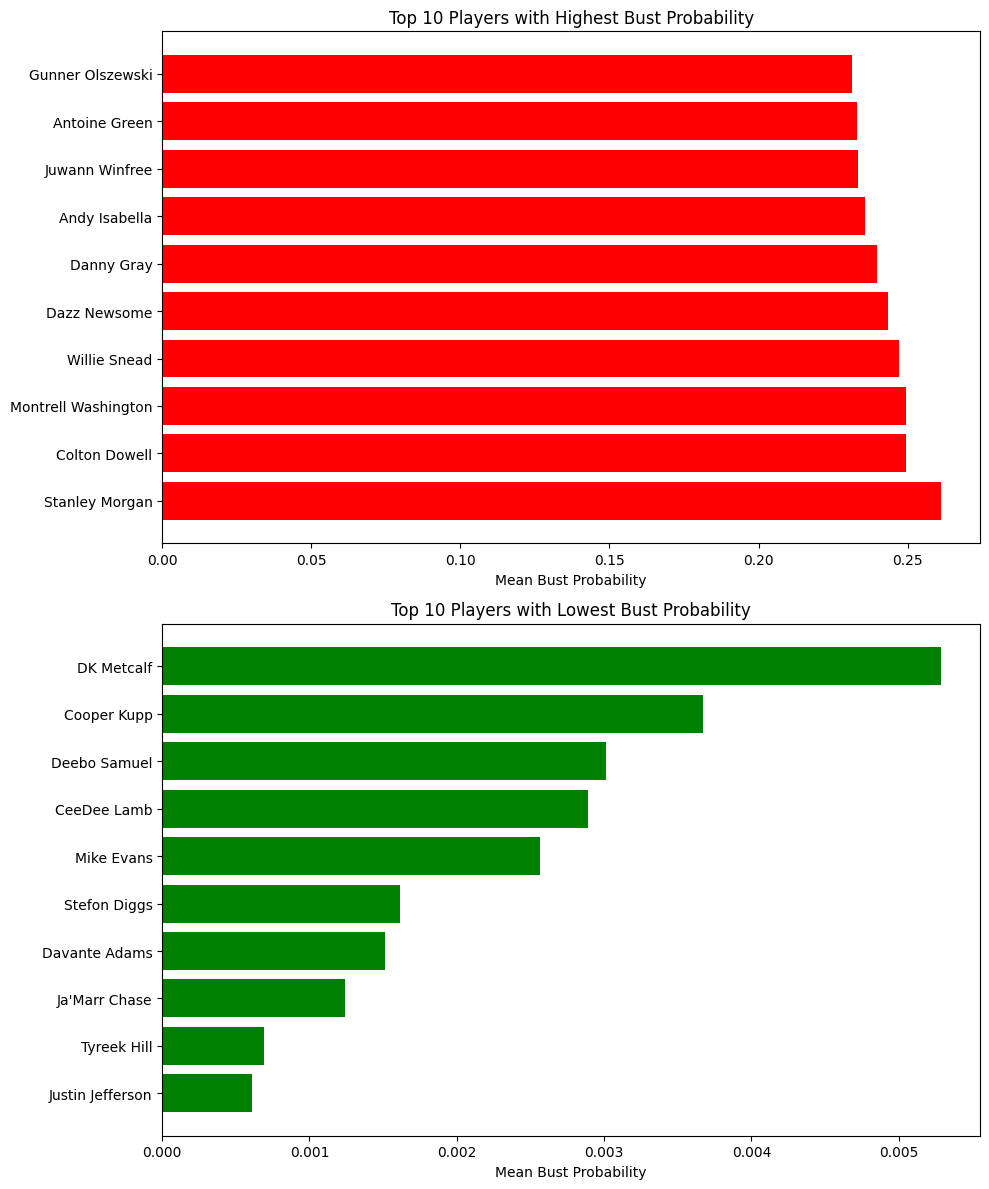

In [ ]:
bust_probs = fit['bust_linpred']

# Convert log odds to probabilities using logistic function
bust_probs = 1 / (1 + np.exp(-bust_probs))

# Averaging bust probabilities over each player-season
# We will use 'receiver_index' to map bust probabilities back to player-seasons, assuming 'receiver_index' is aligned with player-season in merged_data
merged_data['bust_prob'] = bust_probs.mean(axis=1)  # mean across MCMC samples

# Group by player-season to get the mean probability for each player-season
player_season_avg = merged_data.groupby(['player_display_name', 'season'])['bust_prob'].mean().reset_index()

# Aggregate to get the mean probability for each player across seasons
player_bust_probs = player_season_avg.groupby('player_display_name')['bust_prob'].mean().reset_index()

# Sort and select the top and bottom 10 players
top_bust_probs = player_bust_probs.nlargest(10, 'bust_prob')
bottom_bust_probs = player_bust_probs.nsmallest(10, 'bust_prob')

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Top 10 highest bust probabilities
ax[0].barh(top_bust_probs['player_display_name'], top_bust_probs['bust_prob'], color='red')
ax[0].set_title('Top 10 Players with Highest Bust Probability')
ax[0].set_xlabel('Mean Bust Probability')

# Top 10 lowest bust probabilities
ax[1].barh(bottom_bust_probs['player_display_name'], bottom_bust_probs['bust_prob'], color='green')
ax[1].set_title('Top 10 Players with Lowest Bust Probability')
ax[1].set_xlabel('Mean Bust Probability')

plt.tight_layout()
plt.show()

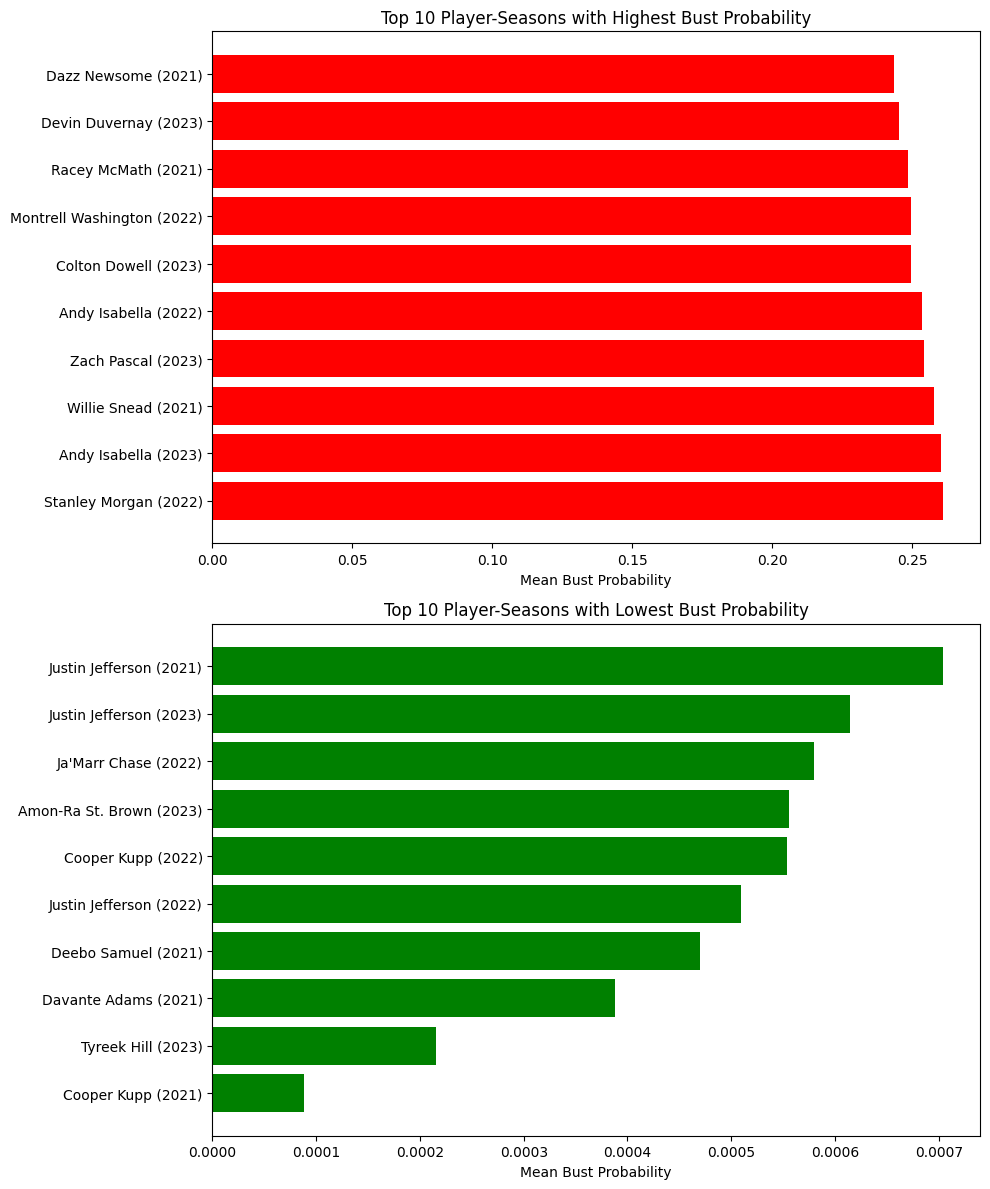

In [ ]:
bust_probs = fit['bust_linpred']

# Convert log odds to probabilities using the logistic function
bust_probs = 1 / (1 + np.exp(-bust_probs))

# Assume merged_data has columns 'player_display_name' and 'season' that uniquely identify each player-season
# Also assume 'receiver_index' in merged_data correctly maps each row in 'bust_probs' to these player-seasons
# Add calculated probabilities back to merged_data
merged_data['bust_prob'] = bust_probs.mean(axis=1)  # Average across MCMC samples for each game

# Group by player and season to calculate the average bust probability for each player-season
player_season_avg = merged_data.groupby(['player_display_name', 'season'])['bust_prob'].mean().reset_index()

# Find the top 10 player-seasons with the highest and lowest bust probabilities
top_bust_probs = player_season_avg.nlargest(10, 'bust_prob')
bottom_bust_probs = player_season_avg.nsmallest(10, 'bust_prob')

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Top 10 highest bust probabilities
ax[0].barh(top_bust_probs['player_display_name'] + ' (' + top_bust_probs['season'].astype(str) + ')', top_bust_probs['bust_prob'], color='red')
ax[0].set_title('Top 10 Player-Seasons with Highest Bust Probability')
ax[0].set_xlabel('Mean Bust Probability')

# Top 10 lowest bust probabilities
ax[1].barh(bottom_bust_probs['player_display_name'] + ' (' + bottom_bust_probs['season'].astype(str) + ')', bottom_bust_probs['bust_prob'], color='green')
ax[1].set_title('Top 10 Player-Seasons with Lowest Bust Probability')
ax[1].set_xlabel('Mean Bust Probability')

plt.tight_layout()
plt.show()

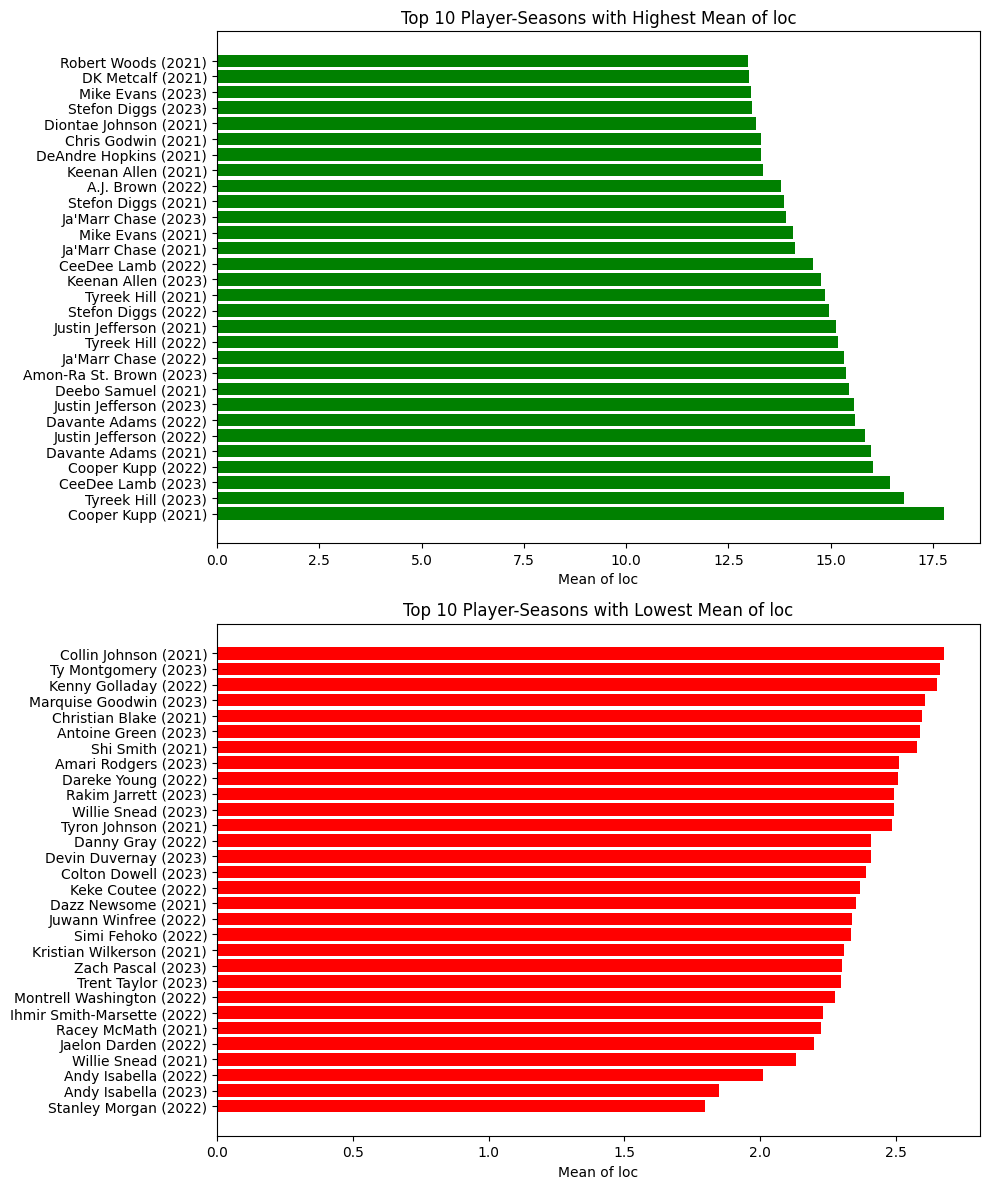

In [ ]:
loc_means = fit['loc'].mean(axis=1)  # mean across MCMC samples

# Create a DataFrame for 'loc' means that aligns with 'receiver_index'
loc_df = pd.DataFrame({
    'receiver_index': np.arange(1, len(loc_means) + 1),
    'loc_mean': loc_means
})

# Merge this DataFrame with 'merged_data' to associate loc means with player names and seasons
# Ensure 'receiver_index' in 'merged_data' is used to merge
merged_loc_data = pd.merge(merged_data, loc_df, on='receiver_index')

# Group by player and season to calculate the mean loc value for each player-season
player_season_avg = merged_loc_data.groupby(['player_display_name', 'season'])['loc_mean'].mean().reset_index()

# Find the top 10 player-seasons with the highest and lowest loc means
top_loc_means = player_season_avg.nlargest(30, 'loc_mean')
bottom_loc_means = player_season_avg.nsmallest(30, 'loc_mean')

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Top 10 highest loc means
ax[0].barh(top_loc_means['player_display_name'] + ' (' + top_loc_means['season'].astype(str) + ')', top_loc_means['loc_mean'], color='green')
ax[0].set_title('Top 10 Player-Seasons with Highest Mean of loc')
ax[0].set_xlabel('Mean of loc')

# Top 10 lowest loc means
ax[1].barh(bottom_loc_means['player_display_name'] + ' (' + bottom_loc_means['season'].astype(str) + ')', bottom_loc_means['loc_mean'], color='red')
ax[1].set_title('Top 10 Player-Seasons with Lowest Mean of loc')
ax[1].set_xlabel('Mean of loc')

plt.tight_layout()
plt.show()

#Max Sampling

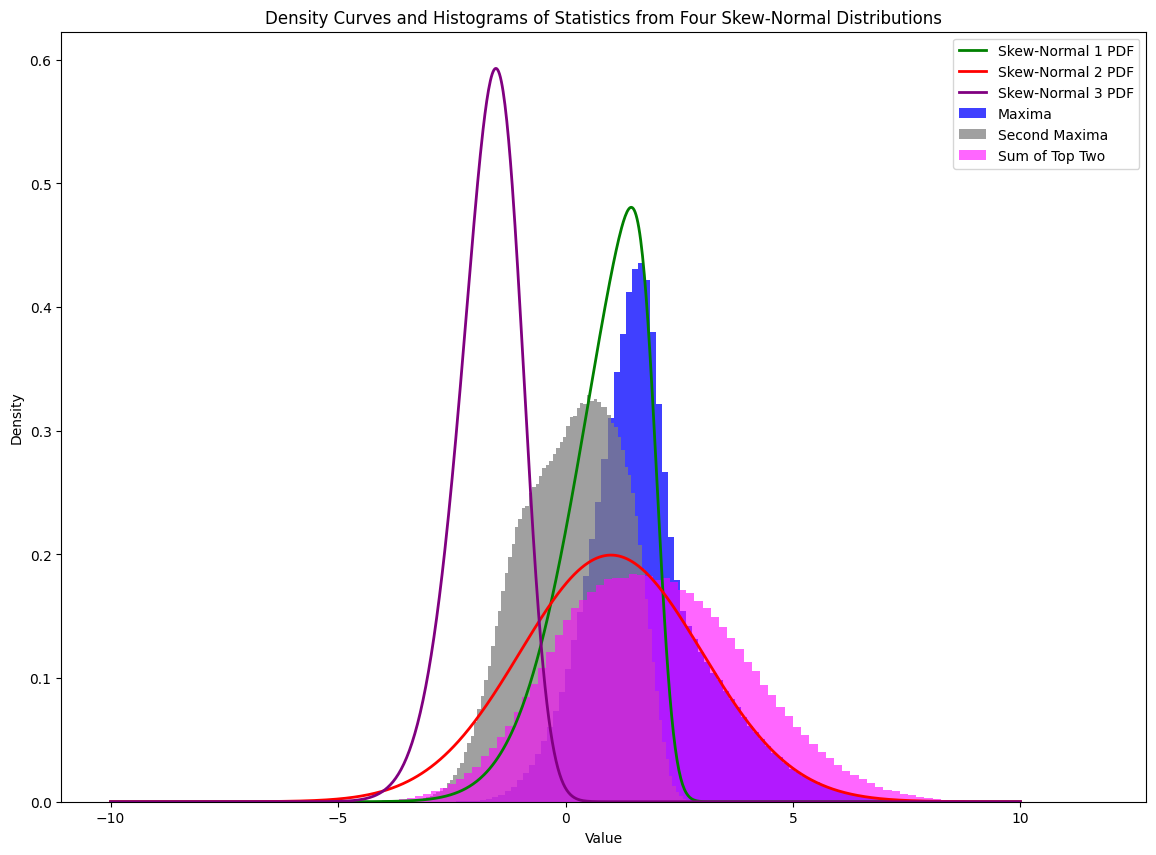

In [ ]:
def sample_stats_skew_normals(size, params_list):
    """
    Samples from four skew-normal distributions and computes statistics:
    max, second max, and the sum of the top two values.

    Parameters:
        size (int): Number of samples to generate.
        params_list (list of tuples): Parameters (alpha, loc, scale) for each skew-normal distribution.

    Returns:
        np.array: An array of the maxima of samples from the four distributions.
        np.array: An array of the second maxima.
        np.array: An array of the sum of the top two samples.
        list of np.array: List of PDF values for the x range, one for each distribution.
    """
    # Generate samples and compute PDFs
    samples = []
    pdfs = []
    x_range = np.linspace(-10, 10, 1000)  # Define range for plotting PDFs

    for alpha, loc, scale in params_list:
        sample = skewnorm.rvs(alpha, loc, scale, size=size)
        samples.append(sample)
        pdf = skewnorm.pdf(x_range, alpha, loc, scale)
        pdfs.append(pdf)

    # Stack samples horizontally and sort each row in descending order
    samples_stack = np.column_stack(samples)
    sorted_samples = np.sort(samples_stack, axis=1)[:, ::-1]

    # Compute statistics
    maxima = sorted_samples[:, 0]
    second_maxima = sorted_samples[:, 1]
    sum_top_two = sorted_samples[:, 0] + sorted_samples[:, 1]

    return maxima, second_maxima, sum_top_two, pdfs, x_range

# Define parameters for the distributions
params_list = [
    #(5, 0, 1),
    (-5, 2, 1.5),
    (0, 1, 2),
    (-2, -1, 1)
]

# Generate samples and calculate statistics
maxima, second_maxima, sum_top_two, pdfs, x_range = sample_stats_skew_normals(1000000, params_list)

# Plotting the results
plt.figure(figsize=(14, 10))
colors = ['green', 'red', 'purple', 'orange']
for i, pdf in enumerate(pdfs):
    plt.plot(x_range, pdf, color=colors[i], linewidth=2, label=f'Skew-Normal {i+1} PDF')
plt.hist(maxima, bins=100, alpha=0.75, color='blue', density=True, label='Maxima')
plt.hist(second_maxima, bins=100, alpha=0.75, color='grey', density=True, label='Second Maxima')
plt.hist(sum_top_two, bins=100, alpha=0.6, color='magenta', density=True, label='Sum of Top Two')
plt.title('Density Curves and Histograms of Statistics from Four Skew-Normal Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()